In [144]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-scoring-with-xgboost2023/data_devsample.csv
/kaggle/input/credit-risk-scoring-with-xgboost2023/data_to_score.csv


Показываем все строки при выводе
Сделано для удобства EDA

In [145]:
pd.set_option('display.max_rows', None)

# 0.Загрузка и первичный осмотр

In [146]:
devsample = pd.read_csv('/kaggle/input/credit-risk-scoring-with-xgboost2023/data_devsample.csv')
devsample.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE,MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_CLOSED,FIRST_TRANSACTION_TIME_MONTHS,LAST_TRANSACTION_TIME_MONTHS,TIME,BASE,DAY,MONTH
0,215138,0.0,Cash loans,M,N,Y,0.0,135000.0,646920.0,25195.5,...,0.0,NaN,0.0,NaN,37.0,28.0,2018-06-23,1,20180623,201806
1,325963,0.0,Cash loans,M,Y,Y,0.0,135000.0,740218.5,40284.0,...,0.0,0.0,0.0,NaN,3.0,18.0,2018-06-16,1,20180616,201806
2,206923,0.0,Cash loans,F,N,Y,0.0,180000.0,339241.5,12919.5,...,0.0,NaN,0.0,NaN,73.0,61.0,2018-06-19,1,20180619,201806
3,265855,0.0,Cash loans,F,N,Y,0.0,180000.0,1264428.0,37098.0,...,0.0,0.0,NaN,NaN,36.0,4.0,2018-08-09,1,20180809,201808
4,359795,0.0,Revolving loans,F,N,Y,NaN,76500.0,202500.0,10125.0,...,NaN,NaN,0.0,0.0,12.0,12.0,2018-11-13,1,20181113,201811


In [147]:
devsample.shape, devsample.dtypes.value_counts()

((80000, 197),
 float64    139
 int64       41
 object      17
 Name: count, dtype: int64)

#### Видим, что у нас много числовых признаков, а также есть интовые, часть из которых вероятно будут на деле булевыми. Это надо будет обработать

# 1. Распределения признаков

## 1.1 Таргет

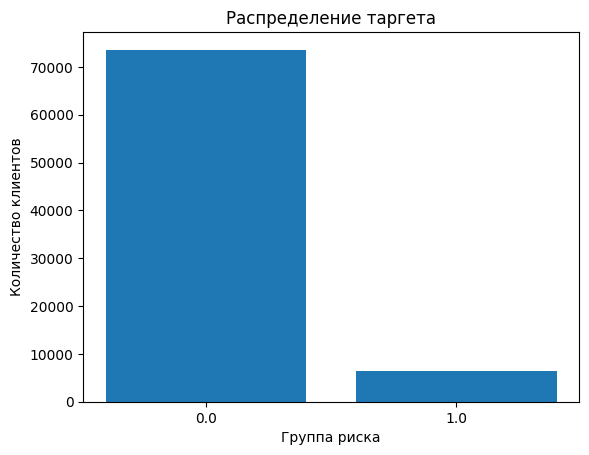

In [148]:
import matplotlib.pyplot as plt

# Распределение целевого значения
target_counts = devsample['TARGET'].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(target_counts.index.astype(str), target_counts.values)
ax.set_xlabel('Группа риска')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение таргета')
plt.show()

#### Наблюдаем сильный дисбаланс классов, что необходимо будет учитывать при дальнейшем анализе и построении модели

### Делим признаки на типы

In [149]:
 # Копируем исходный датасет чтобы не затирать его
df = devsample.copy()

# Приводим все пропущенные значения к NaN
df = df.replace([np.inf, -np.inf], np.nan)

missing_tokens = ['XNA', 'Unknown', 'UNKNOWN', 'NA', 'N/A', ' ', '']
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].replace(missing_tokens, np.nan)

# 1. разрез: числовые и категориальные
num_cols = df.drop(columns=['TARGET']).select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.drop(columns=['TARGET', 'TIME']).select_dtypes(include=["object"]).columns.tolist()

# 2. разрез: бинарные и остальные числовые
binary_cols = []
for col in num_cols:
    vals = df[col].dropna().unique()
    # если максимум 2 уникальных значения и они подмножество {0,1}
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        binary_cols.append(col)
nonbinary_cols = [c for c in num_cols if c not in binary_cols]

print("Бинарные числовые:", len(binary_cols))
print("Небинарные числовые:", len(nonbinary_cols))
print("Категориальные:", len(cat_cols))

Бинарные числовые: 39
Небинарные числовые: 140
Категориальные: 16


Как и ожидалось - мы имеем примерно столько же бинарных признаков, сколько и интовых значений в исходном датасете

При этом есть много числовых, на распределение которых надо смотреть

## 1.2 Числовые

Ниже — итоговые выводы по таблице Describe

In [150]:
# Отбираем только числовые
df_nums = df[nonbinary_cols]

# Делаем усовершенствованный Describe с допольнительными процентилями
num_desc = df_nums.describe(
    percentiles=[0.01, 0.5, 0.99],
    include=[np.number]
    
).T  # признаки по строкам

# Добавляем пару значений
num_desc["n_unique"] = df_nums.nunique() # Количество уникальных значений
num_desc["missing_ratio"] = df_nums.isna().mean() # Количество пропусков

# Приводим числа к удобному формату
num_desc_styled = num_desc.style.format("{:,.3f}".format)
num_desc_styled

,count,mean,std,min,1%,50%,99%,max,n_unique,missing_ratio
SK_ID_CURR,"80,000.000","278,160.919","102,712.984","100,002.000","103,497.970","278,856.500","452,377.140","456,251.000","80,000.000",0.000
CNT_CHILDREN,"55,035.000",0.325,0.638,0.000,0.000,0.000,2.000,12.000,10.000,0.312
AMT_INCOME_TOTAL,"80,000.000","168,266.292","109,277.519","26,100.000","45,000.000","148,500.000","472,500.000","13,500,000.000","1,059.000",0.000
AMT_CREDIT,"80,000.000","598,241.906","400,205.112","45,000.000","76,500.000","513,531.000","1,831,887.000","4,050,000.000","3,906.000",0.000
AMT_ANNUITY,"79,994.000","27,115.321","14,471.546","1,980.000","6,182.685","24,939.000","69,754.500","225,000.000","10,121.000",0.000
AMT_GOODS_PRICE,"79,937.000","537,606.227","367,400.605","40,500.000","67,500.000","450,000.000","1,800,000.000","4,050,000.000",603.000,0.001
REGION_POPULATION_RELATIVE,"80,000.000",0.021,0.014,0.001,0.002,0.019,0.073,0.073,80.000,0.000
DAYS_BIRTH,"59,780.000","-16,031.077","4,365.529","-25,187.000","-24,376.210","-15,754.000","-8,260.000","-7,489.000","16,189.000",0.253
DAYS_EMPLOYED,"80,000.000","63,636.234","141,122.464","-17,531.000","-10,928.040","-1,215.000","365,243.000","365,243.000","9,275.000",0.000
DAYS_REGISTRATION,"80,000.000","-4,978.925","3,514.338","-23,738.000","-13,861.010","-4,502.000",-47.990,0.000,"13,693.000",0.000


### Итоговые выводы по числовым признакам

1. **Технические идентификаторы**
   - `SK_ID_CURR` — чистый ID, не несёт предсказательной информации.
   - В модели должен **исключаться**, но оставаться в исходном датафрейме.

2. **Временные / календарные признаки**
   - `DAY` и `MONTH` и `TIME` — это закодированные даты/время.
   - Необходимо либо создать из них новые фичи (сезонность, тренд и т.д.) либо удалить их

3. **Сильная скошенность распределений и хвосты**
   - У многих признаков `mean` сильно отличается от `median`, а `max` заметно больше `99%`-квантили.
   - Это говорит о тяжёлых хвостах (особенно у денежных признаков: `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY` и др.).
   - Что делать:
     - Для импутации числовых признаков логичнее использовать **медиану**, а не среднее.
     - Для моделей, чувствительных к масштабу/форме распределения, можно рассмотреть `log(1+p)`

4. **Пропуски и разреженные признаки**
   - Есть большое число признаков с `missing_ratio > 30%` и отдельная группа почти пустых с `missing_ratio > 95%`.
   - Что делать:
     - Признаки с `>95%` пропусков — скорее всего можно удалить как малоинформативные.
     - Для признаков с 30–95% пропусков:
       - Числовые: импутировать **медианой**.
       - Категориальные: использовать отдельную категорию `"MISSING"`.

5. **Технические коды и пропуски**
   - В данных есть :
     - `inf` / `-inf` (вероятно деление на ноль в производных признаках),
     -  `365243` в `DAYS_EMPLOYED` который выделяется из общей картины и скорее всего является аномалией или дефолтным значением,
   - Все такие значения необходимо переделать в `NaN`, а `DAYS_EMPLOYED` дополнительно создать флаг аномалии (`*_ANOM`).

6. **Производные признаки с высокой корреляцией**
   - Надо будет проверить корреляцию признаков, т.к. много производных от одного, которые вероятно связаны между собой
   - Для деревьев окей, но для линейных моделей лучше почистить

7. **Разный масштаб**
   - Признаки имеют разный масштаб и не стандартизованы, что может сказаться на линейных моделях
   

## 1.3 Категориальные и бинарные

Ниже — итоговые выводы по таблице вида:

- `feature` — название признака  
- `category` — значение категории/класса (включая `NaN`)  
- `count` — количество строк с этой категорией  
- `target_mean` — среднее значение `TARGET` (доля дефолтов) по этой категории  

Эта таблица построена для:
- всех **категориальных** признаков (`object`);
- всех **бинарных числовых** признаков (0/1), которые трактуются как категориальные.

In [151]:
# категориальные и бинарные можно определить в одну категорию
cat_binary_cols = binary_cols + cat_cols 

rows = []
for col in cat_binary_cols:
    # берём уникальные значения, включая NaN
    uniques = df[col].unique()
    for val in uniques:
        # Делаем маску для отбора строк
        if pd.isna(val):
            mask = df[col].isna()
        else:
            mask = df[col] == val
        cat_val = val
        cnt = mask.sum() # Берем количество
        target_mean = df.loc[mask, 'TARGET'].mean()
        rows.append({
            "feature": col,
            "category": cat_val,
            "count": int(cnt),
            "target_mean": float(target_mean),
        })

cat_bin_target = (
    pd.DataFrame(rows).sort_values(["feature", "count"], ascending=[True, False]).set_index(["feature", "category"])
)
cat_bin_target

count  \
feature                                            category                               
BASE                                               1                              80000   
CODE_GENDER                                        F                              52488   
                                                   M                              27510   
                                                   NaN                                2   
EMERGENCYSTATE_MODE                                No                             41513   
                                                   NaN                            37892   
                                                   Yes                              595   
FLAG_CONT_MOBILE                                   1                              79860   
                                                   0                                140   
FLAG_DOCUMENT_10                                   0                              80000   
FLAG_DOCUMENT_11                                   0                              79678   
                                                   1                                322   
FLAG_DOCUMENT_12                                   0                              80000   
FLAG_DOCUMENT_13                                   0                              79705   
                                                   1                                295   
FLAG_DOCUMENT_14                                   0                              79734   
                                                   1                                266   
FLAG_DOCUMENT_15                                   0                              79890   
                                                   1                                110   
FLAG_DOCUMENT_16                                   0                              79226   
                                                   1                                774   
FLAG_DOCUMENT_17                                   0                              79985   
                                                   1                                 15   
FLAG_DOCUMENT_18                                   0                              79330   
                                                   1                                670   
FLAG_DOCUMENT_19                                   0                              79961   
                                                   1                                 39   
FLAG_DOCUMENT_2                                    0                              79996   
                                                   1                                  4   
FLAG_DOCUMENT_20                                   0                              79960   
                                                   1                                 40   
FLAG_DOCUMENT_21                                   0                              79968   
                                                   1                                 32   
FLAG_DOCUMENT_3                                    1                              56726   
                                                   0                              23274   
FLAG_DOCUMENT_4                                    0                              79988   
                                                   1                                 12   
FLAG_DOCUMENT_5                                    0                              78819   
                                                   1                               1181   
FLAG_DOCUMENT_6                                    0                              72909   
                                                   1                               7091   
FLAG_DOCUMENT_7                                    0                              79988   
                                                   1                          

### Итоговые выводы по категориальным и бинарным признакам

1. **Константные или почти константные категориальные признаки (`BASE`)**
   - Признак `BASE` имеет только одну категорию. По нему можно отследить среднее таргета `0.0802`. Такое среднее связано с дисбалансом классов
   - Также есть другие признаки, которые включают в себя 99%+ значений
   - Такие признаки почти ничего не дают модели

2. **Логичная и важная сегментация по риску (`ORGANIZATION_TYPE`, `OCCUPATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, `NAME_EDUCATION_TYPE`)**
   - Признаки имеют логичную и усточивую связь с риском. Например, клиенты с высшим образованием имеют более низкий риск чем клиенты со средним или без образования.
   - Признаки информативны и точно могут использоваться

3. **Различное количество уникальных категорий**
   - Есть признаки с небольшим количеством категорий <10, для которых хорошо подойдет one-hot кодирование
   - Есть признаки с большим количеством категорий >10, для которых лучше использовать frequence или в крайнем случае label кодирование, т.к. one-hot приведет к взрыву размерности и большому количеству признаков

4. **Условно бинарные флаги (`CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`)**
   - Эти признаки имеют две категории и могут быть преобразованы в бинарные на этапе предобработки
   - Для них и для бинарных признаков вполне нормально будет оставить столбцы без кодирования. В комбинации они могут дать сильную корреляцию

5. **Категории с очень малым числом наблюдений потенциально шумные**
   - Значения с маленьким `count` часто дают экстремальные или «идеальные» значения `target_mean`, которые неустойчивы статистически.
   - На следующих этапах их стоит объединять в общую категорию (`OTHER`). Для порогового значения можно взять количество записей меньше 1% - 800

6. **Пропуски и специальные значения как отдельный риск-фактор**
   - Категории, соответствующие отсутствию информации (`NaN`, `XNA`, другие маркеры) часто имеют отличный от среднего профиль риска.
   - В предобработке нужно унифицировать такие значения и явно выделять отдельную категорию `"MISSING"`

## Рекомендации для дальнейшей обработки категориальных и бинарных признаков

1. Привести все бинарные признаки (0/1, Y/N, M/F и др.) к единому числовому формату 0/1.
2. Для категориальных признаков с низкой кардинальностью (ограниченное число категорий) использовать one-hot кодирование.
3. Для признаков с большим количеством категорий:
   - Предварительно группировать редкие категории в `OTHER`
   - Применять frequency/label encoding
5. Все явные и скрытые пропуски (NaN, XNA, Unknown и т.п.) унифицировать и кодировать отдельной категорией `"MISSING"`

# 2. Оценка влияния на таргет

## 2.1 Числовые

### 2.1.1 С таргетом

In [152]:
import matplotlib.pyplot as plt

corr_with_target = df[nonbinary_cols + ['TARGET']].corr()['TARGET'].drop('TARGET').sort_values(ascending=False)
# Топ-10 по положительной и отрицательной корреляции
top_pos = corr_with_target.head(10)
top_neg = corr_with_target.tail(10)

print("Топ-10 положительных корреляций с TARGET:")
print(top_pos)
print("Топ-10 отрицательных корреляций с TARGET:")
print(top_neg)

Топ-10 положительных корреляций с TARGET:
DAYS_BIRTH                     0.077205
REGION_RATING_CLIENT_W_CITY    0.061345
STD_DPD_0M_6M                  0.060575
REGION_RATING_CLIENT           0.058619
DAYS_LAST_PHONE_CHANGE         0.052562
DAYS_ID_PUBLISH                0.051976
OWN_CAR_AGE                    0.045613
DAYS_REGISTRATION              0.037810
DEF_30_CNT_SOCIAL_CIRCLE       0.029870
DEF_60_CNT_SOCIAL_CIRCLE       0.027677
Name: TARGET, dtype: float64
Топ-10 отрицательных корреляций с TARGET:
LAST_TRANSACTION_TIME_MONTHS                                           -0.062732
MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED                                         -0.066208
MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED   -0.066534
MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED                                        -0.067653
MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED                                      -0.067695
MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED                                         -0.068678
S

### 2.1.2 Между собой

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


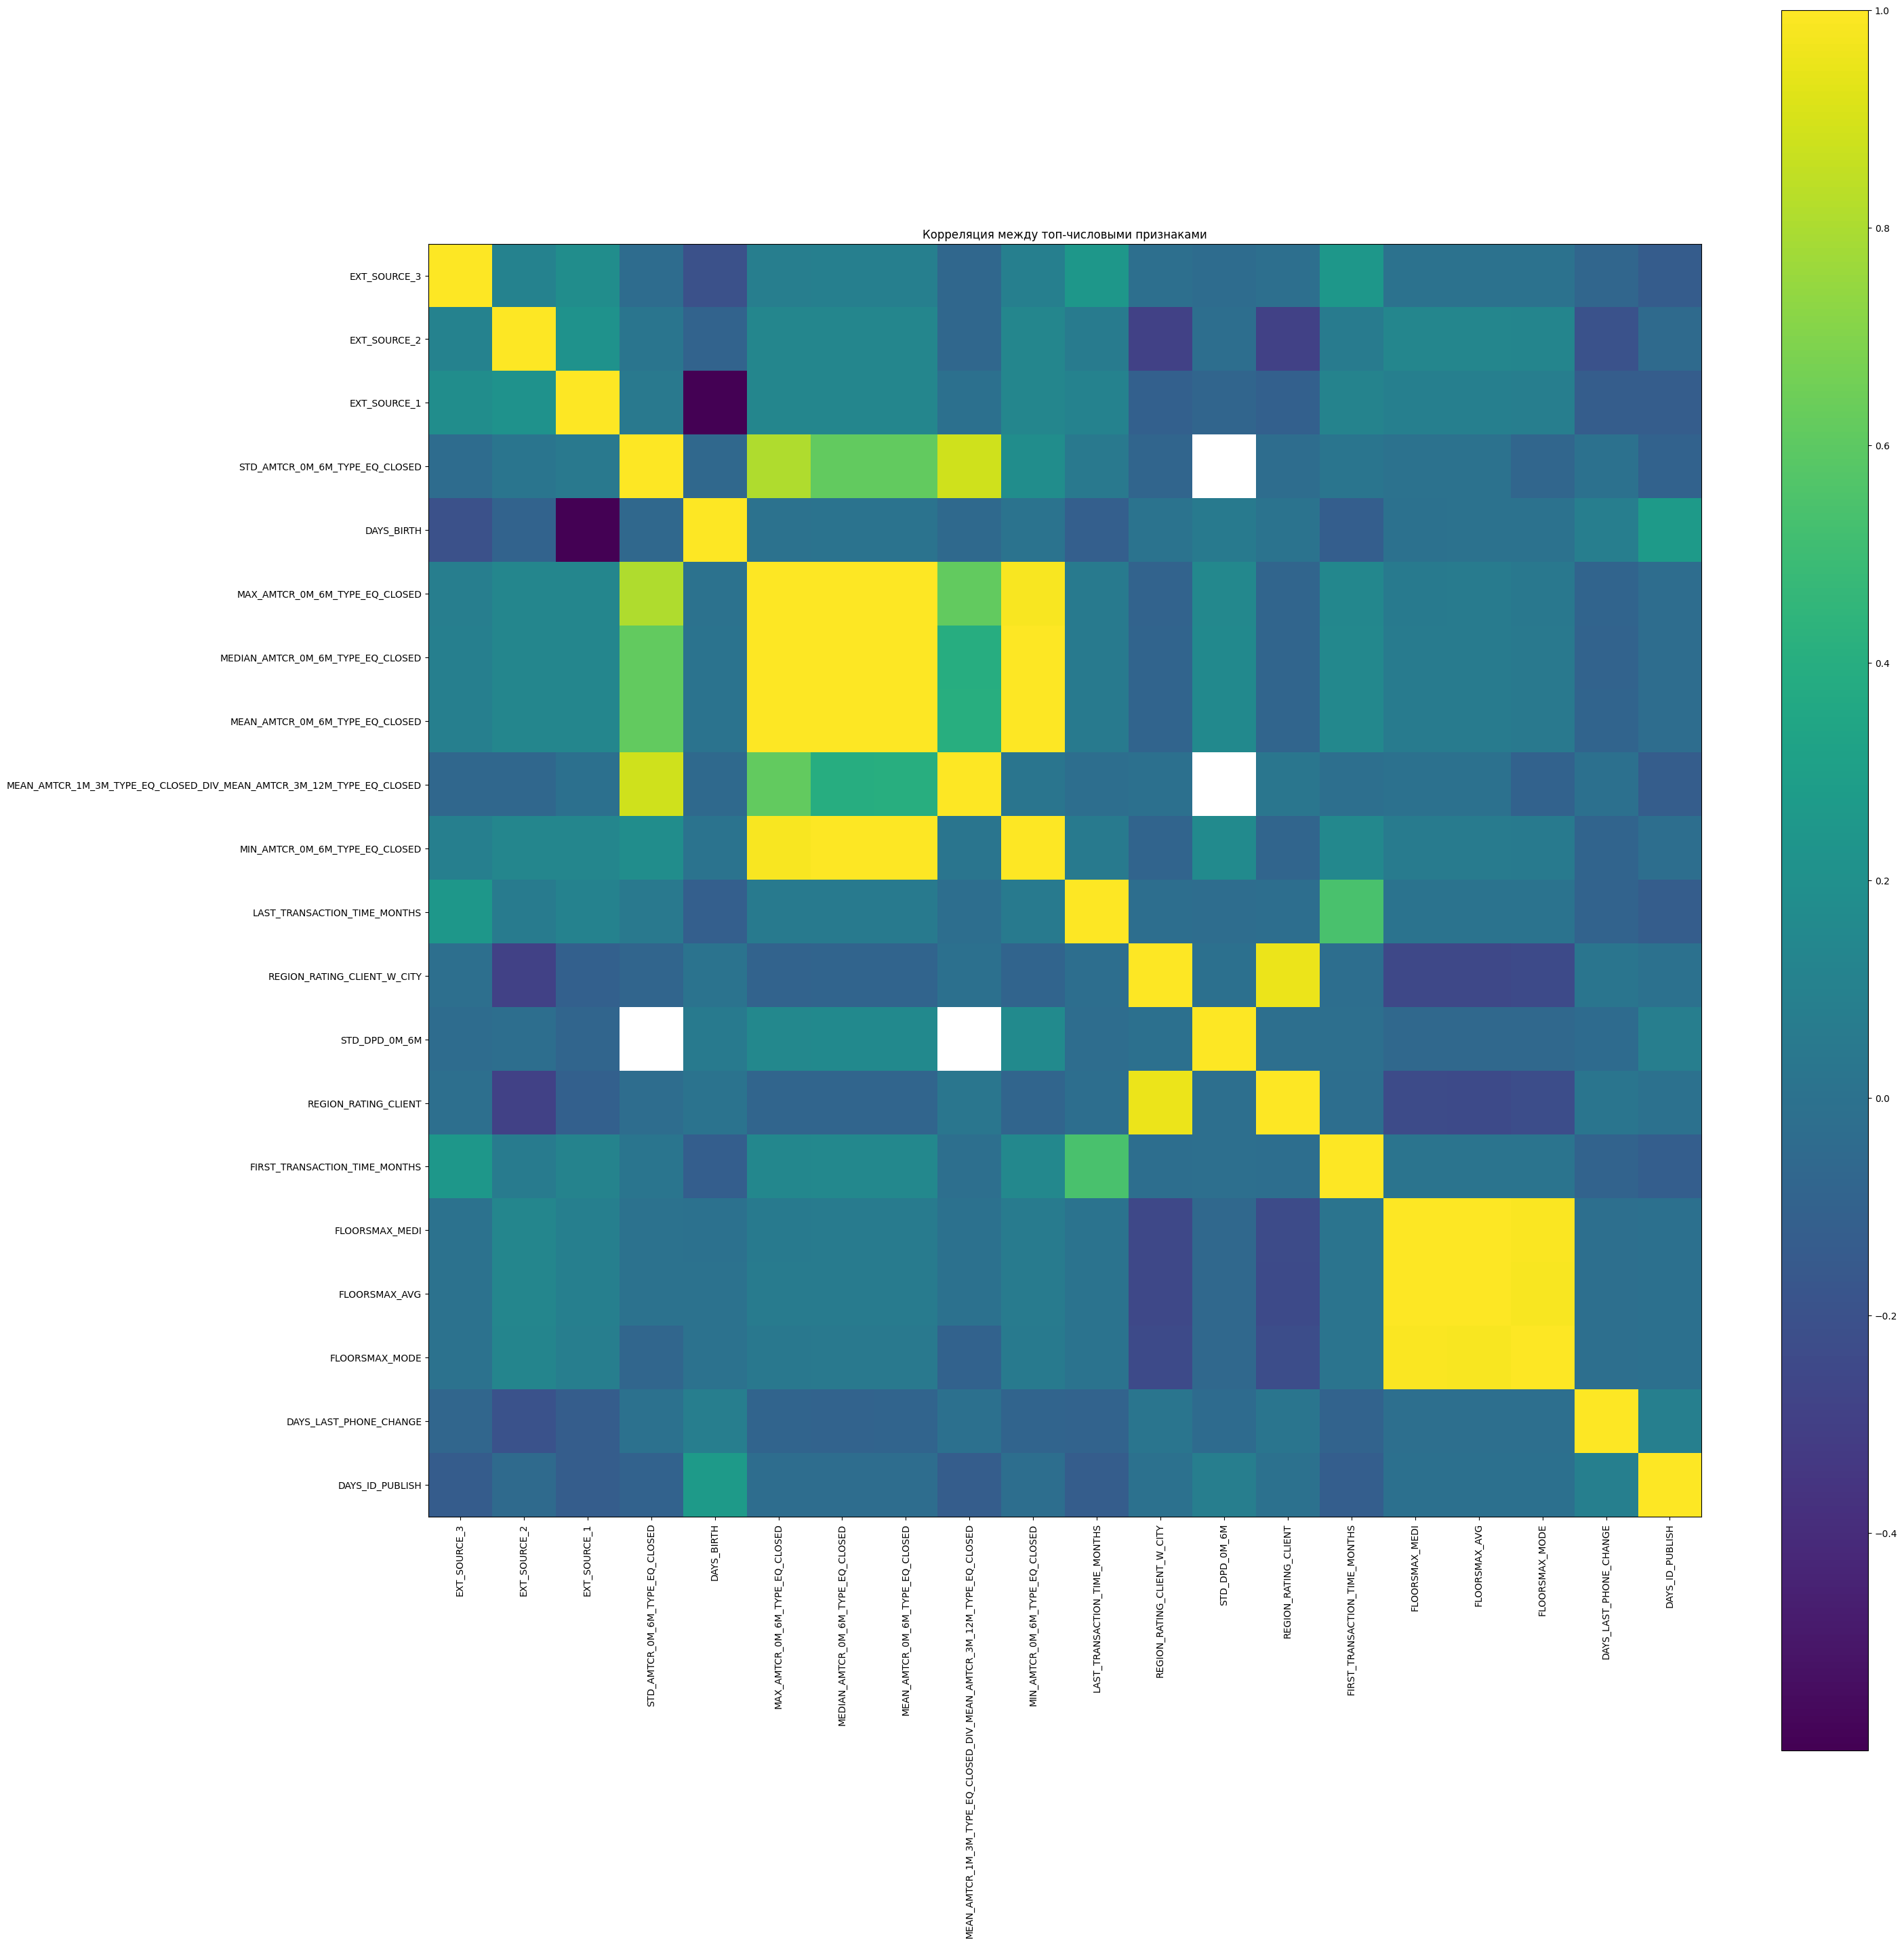

In [153]:
# 4. Тепловая карта корреляций между признаками
# Берём top_k признаков по модулю корреляции с TARGET
top_k = 20
top_features = corr_with_target.abs().sort_values(ascending=False).head(top_k).index.tolist()

corr_matrix = df[top_features].corr()

fig, ax = plt.subplots(figsize=(30, 30))
im = ax.imshow(corr_matrix, interpolation='nearest')

ax.set_xticks(np.arange(len(top_features)))
ax.set_yticks(np.arange(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_yticklabels(top_features)

fig.colorbar(im, ax=ax)
ax.set_title("Корреляция между топ-числовыми признаками")
plt.tight_layout()
plt.show()

## 2.2 Категориальные

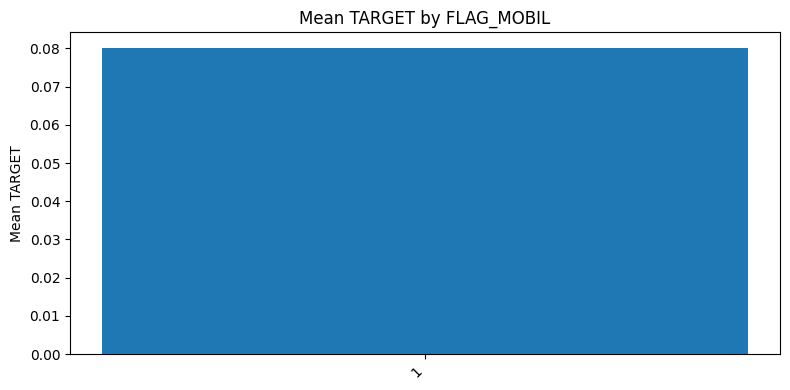

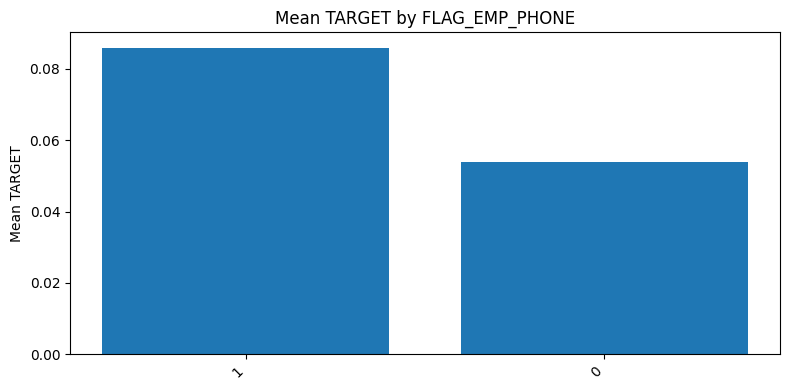

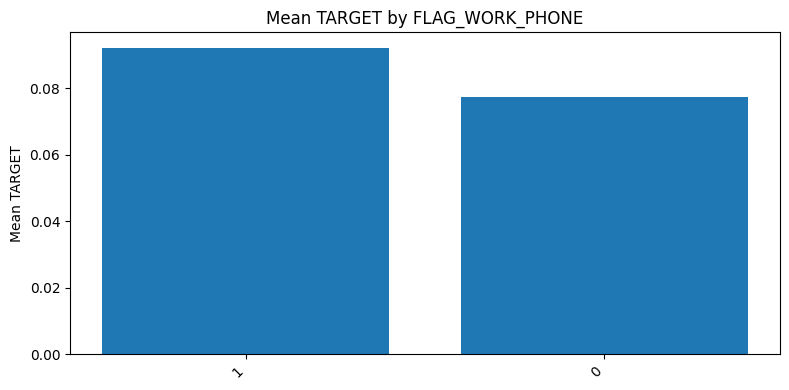

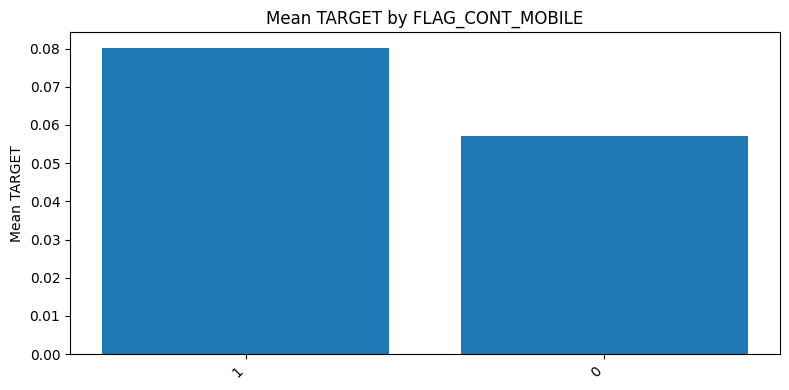

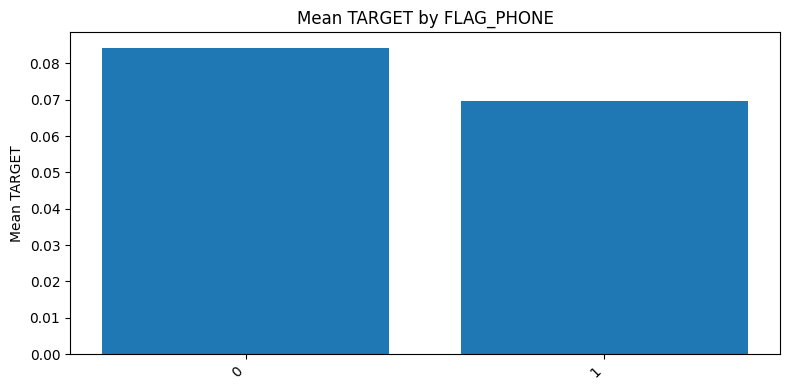

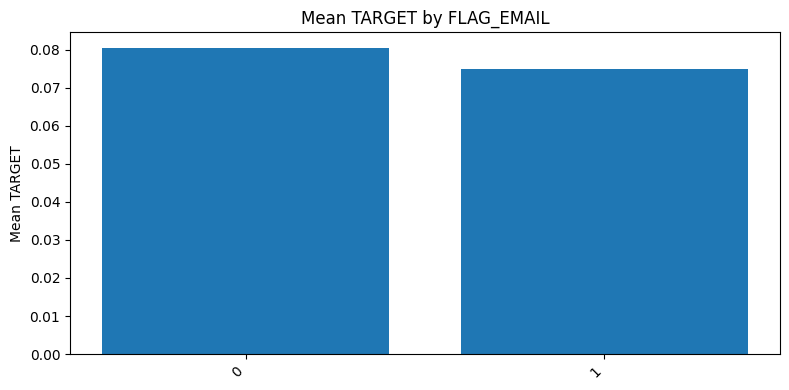

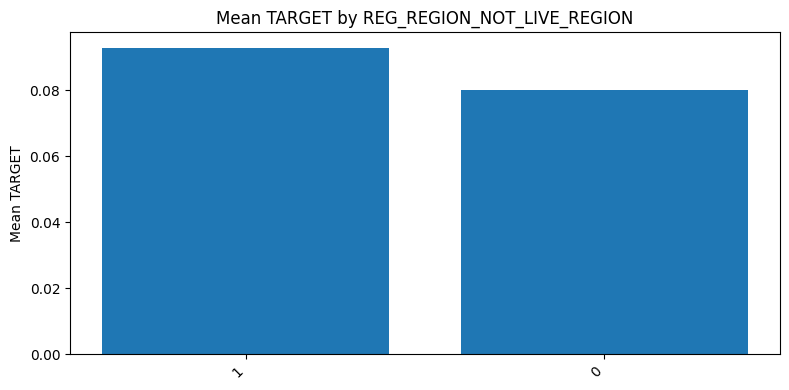

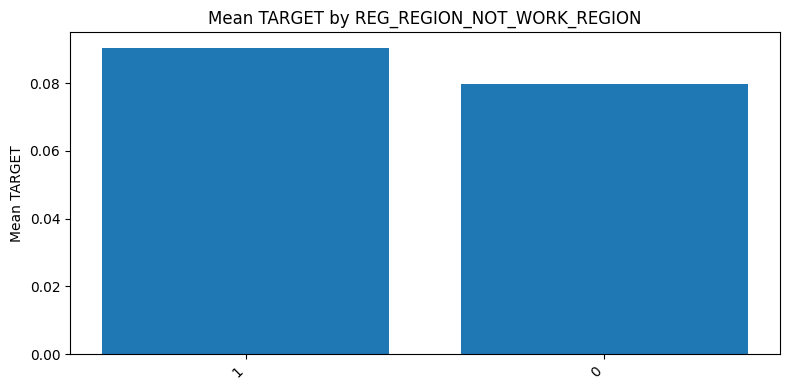

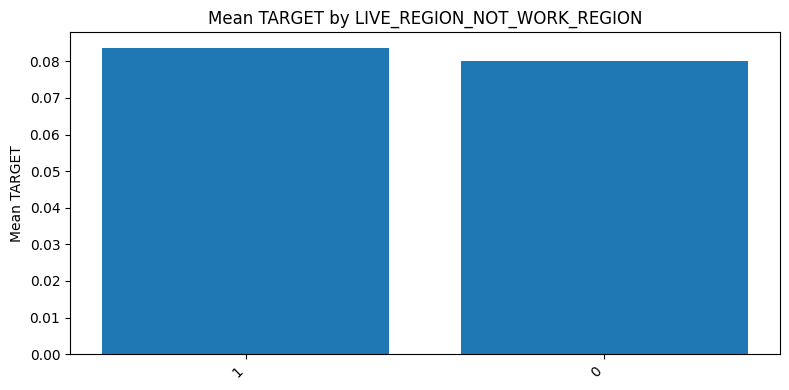

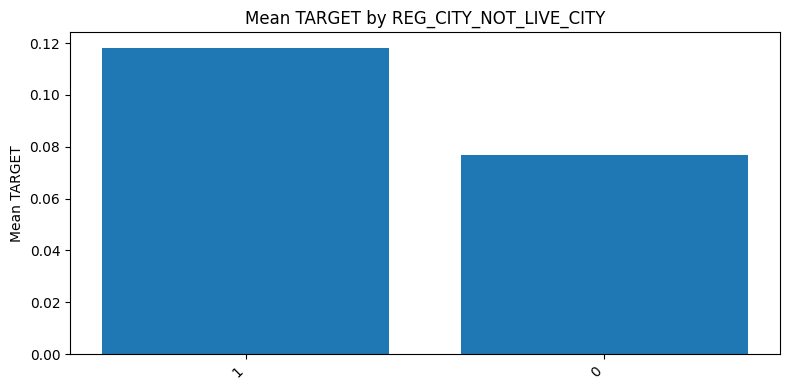

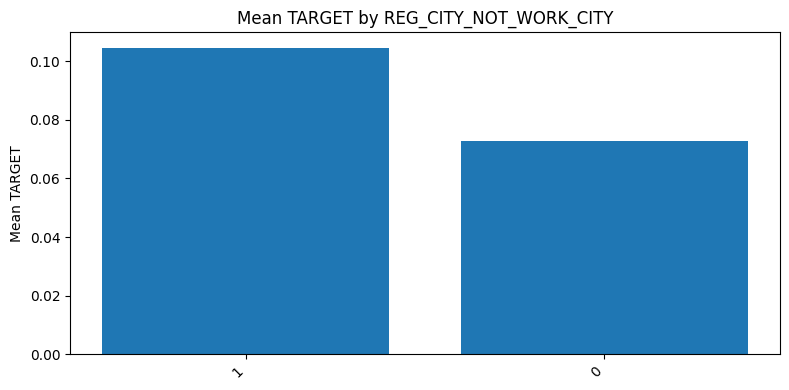

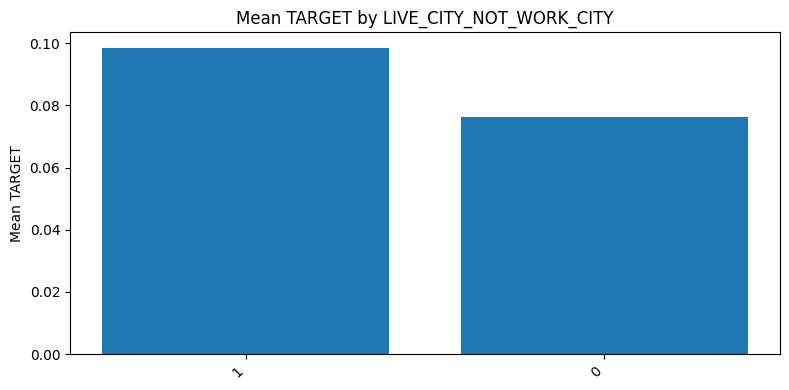

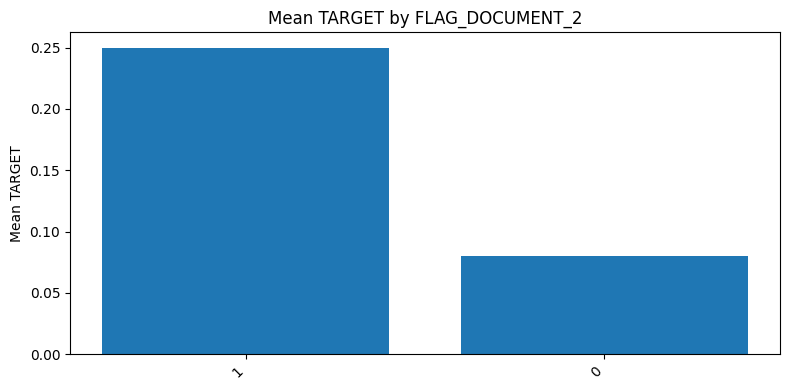

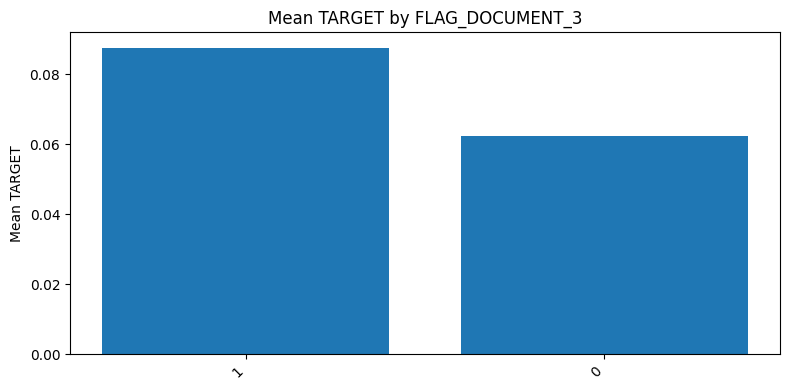

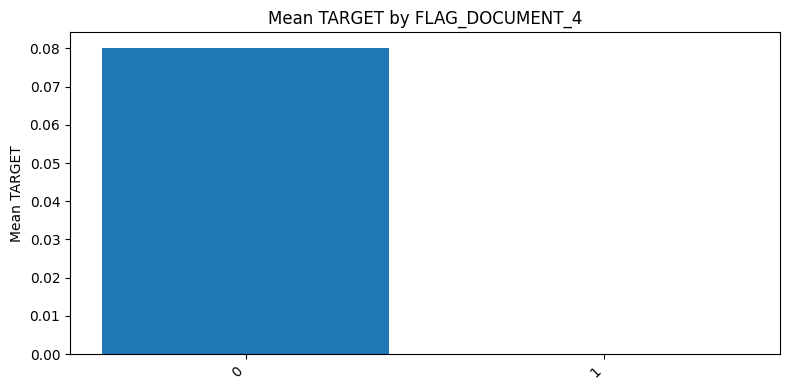

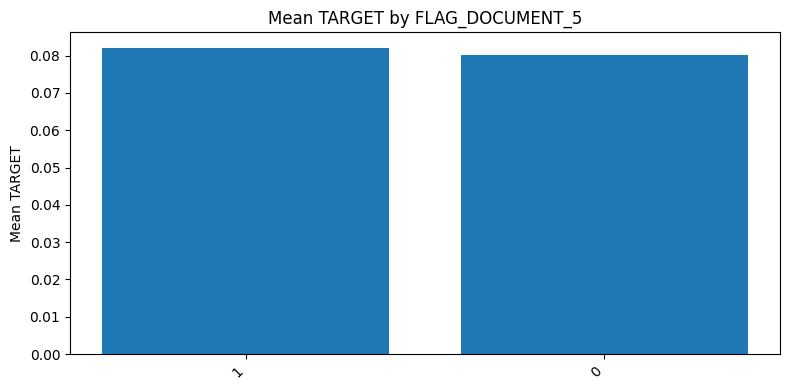

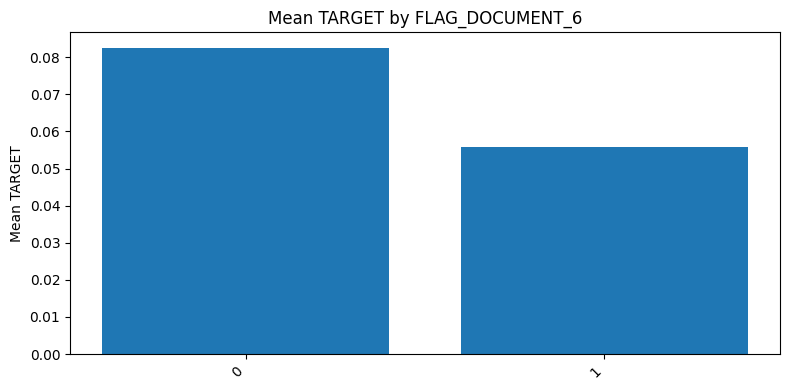

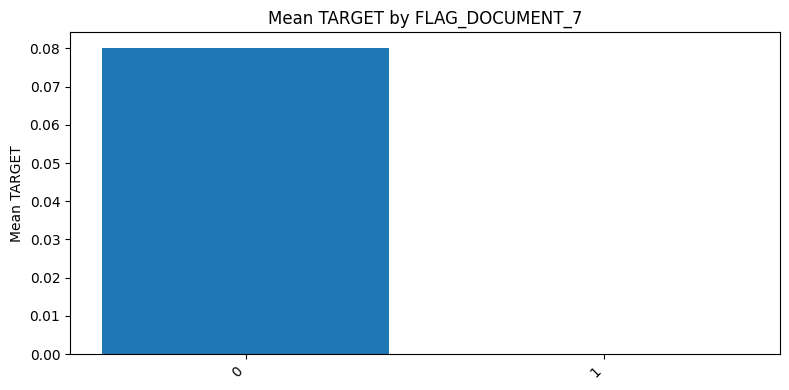

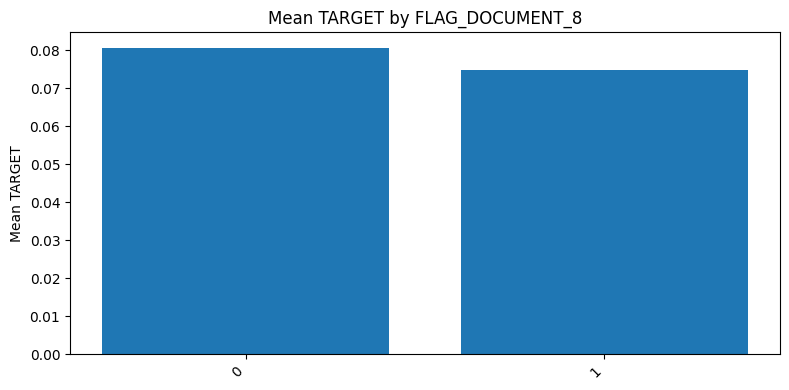

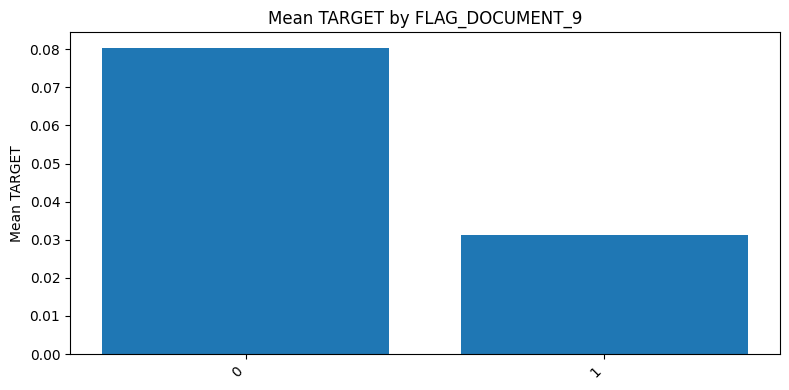

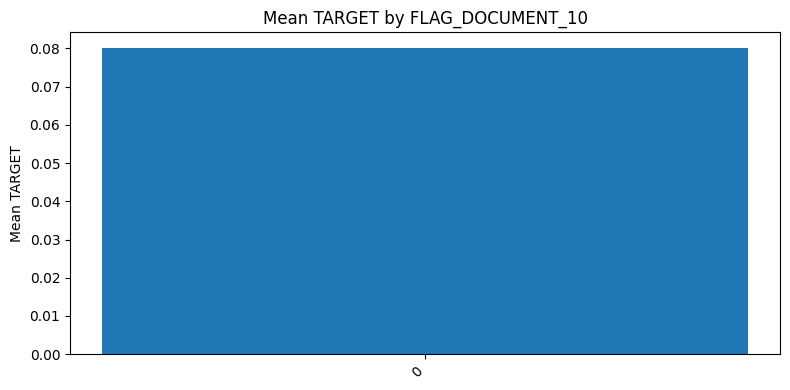

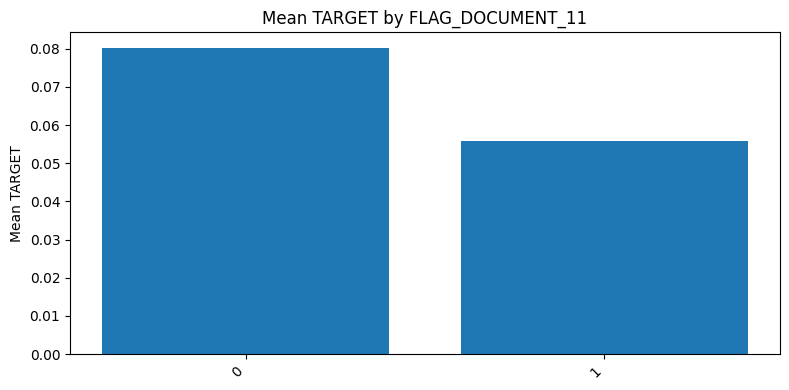

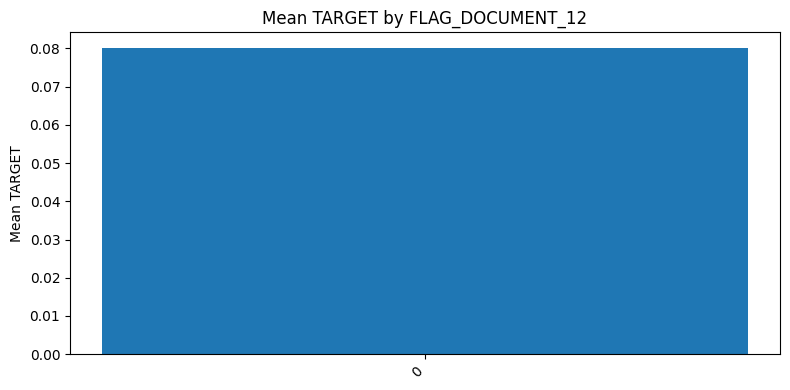

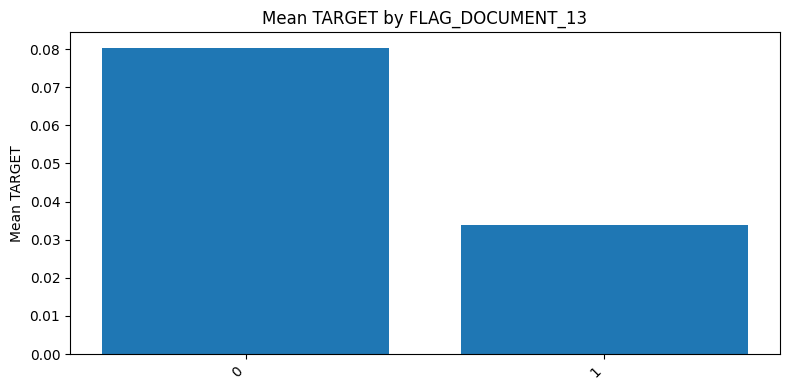

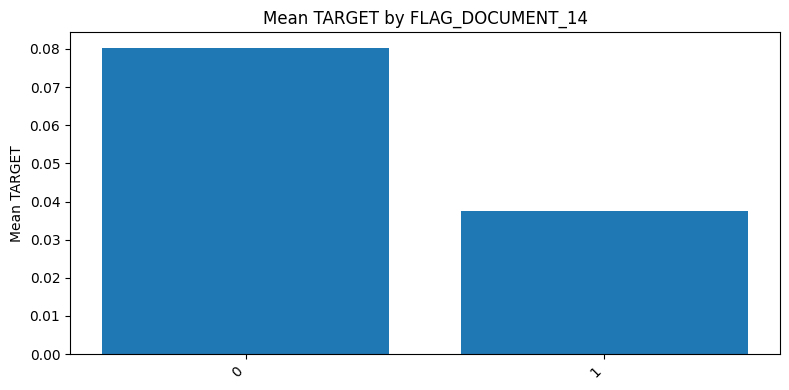

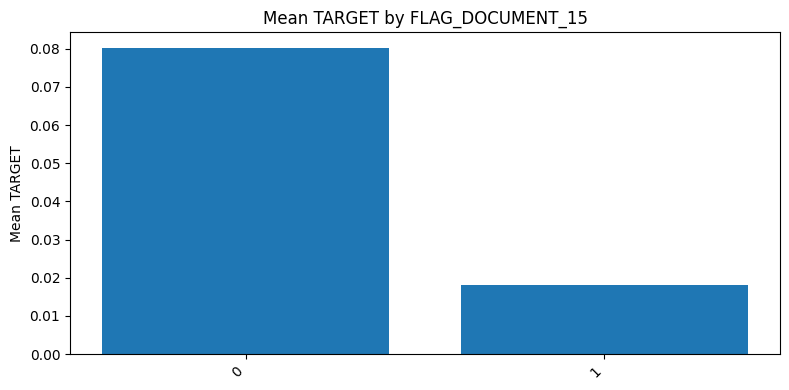

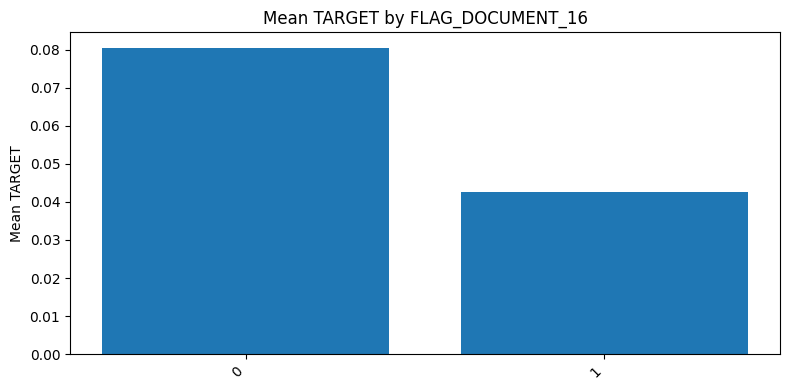

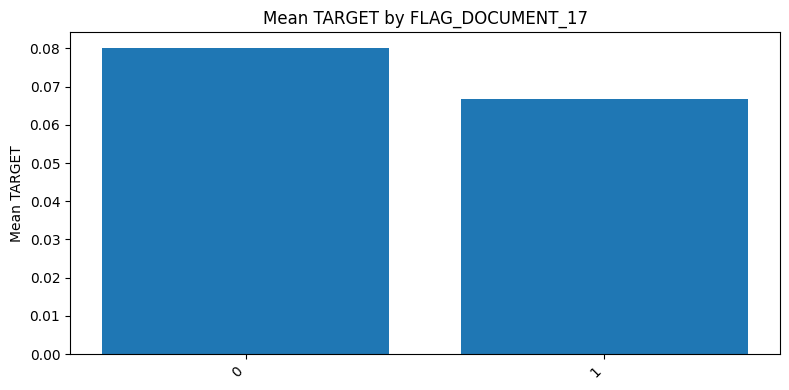

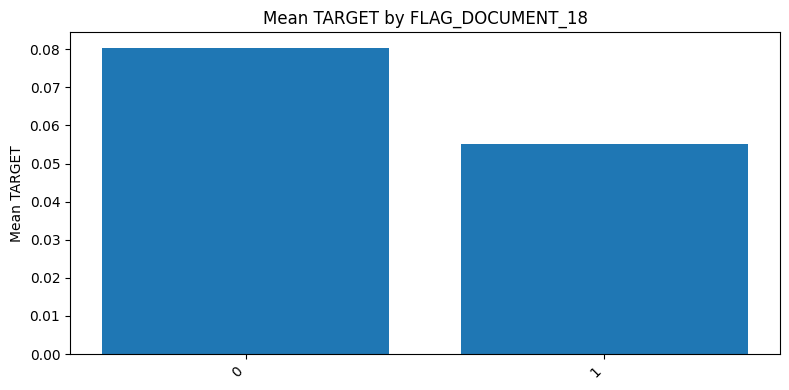

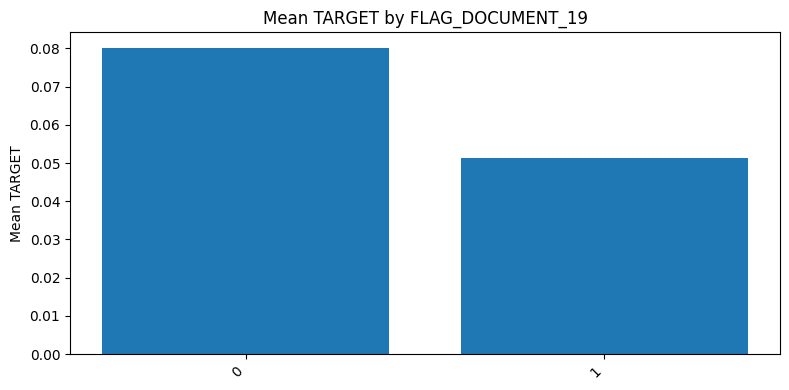

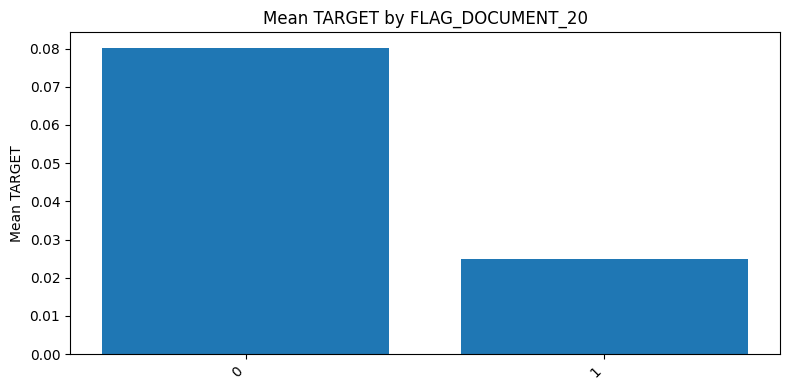

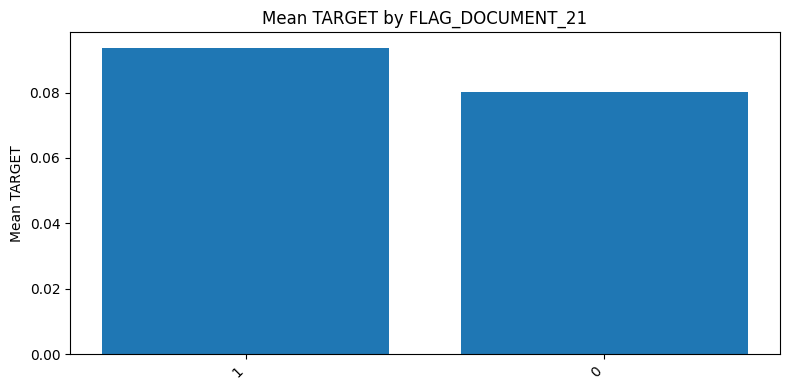

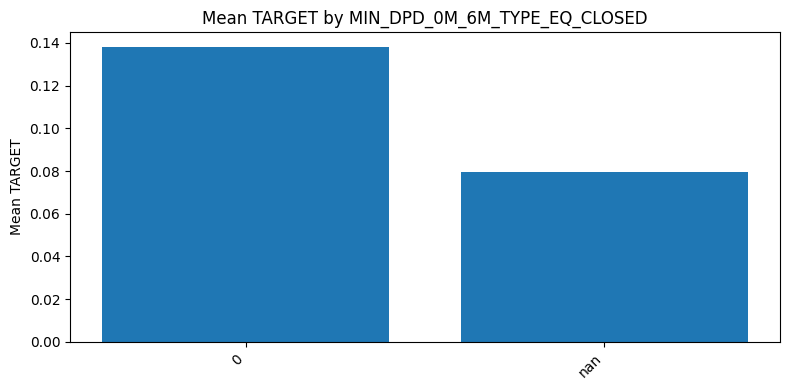

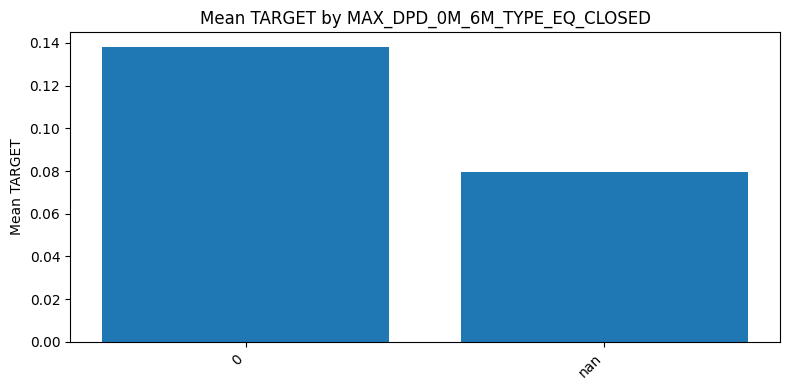

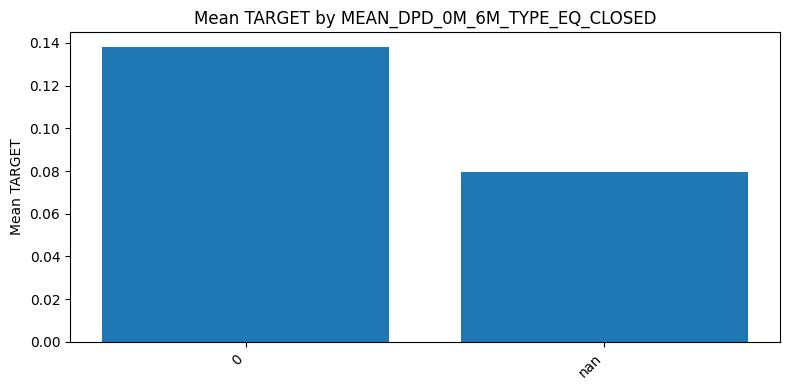

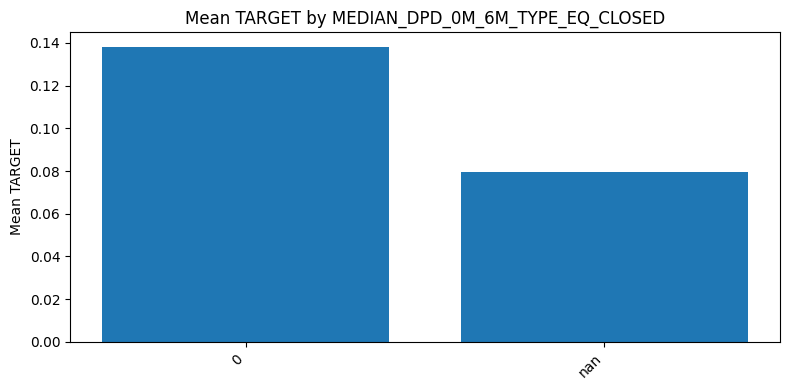

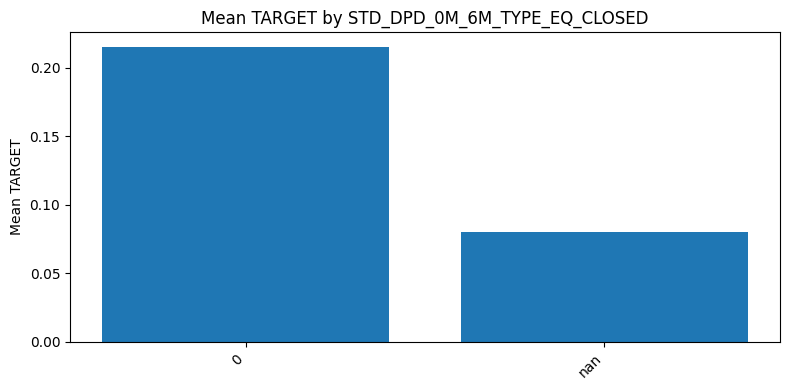

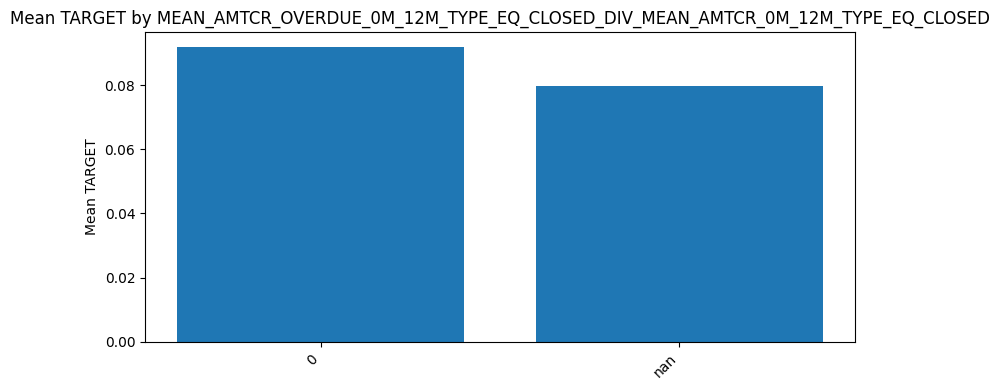

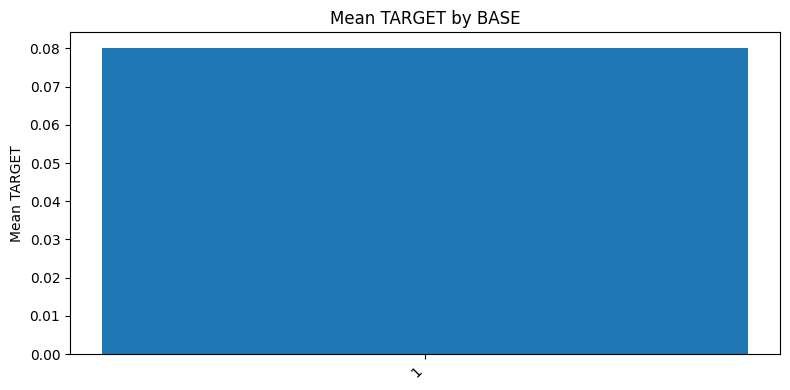

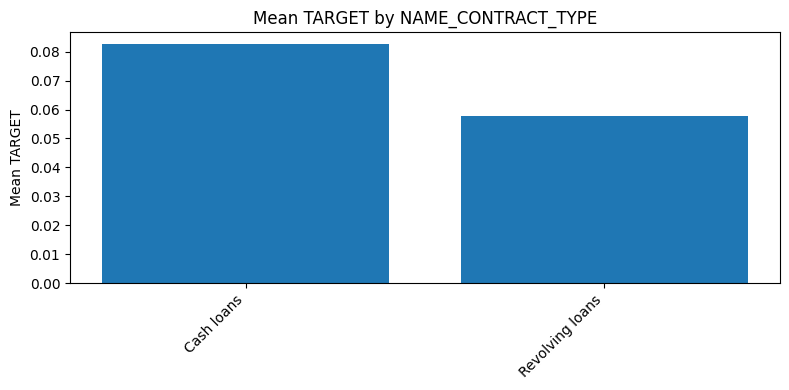

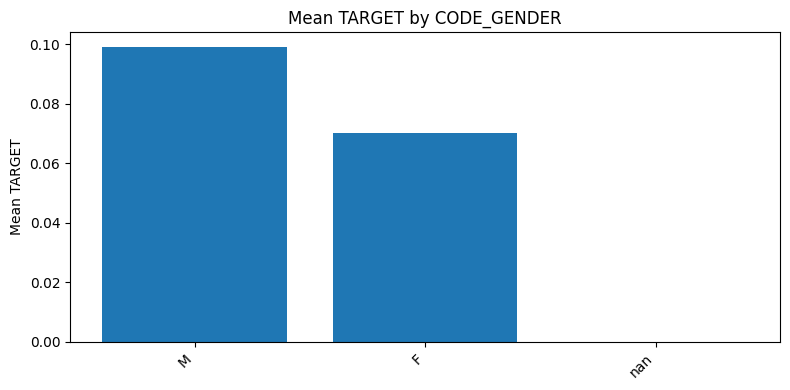

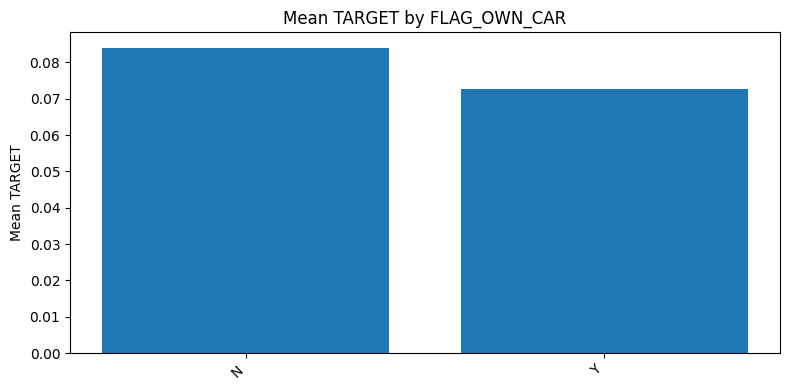

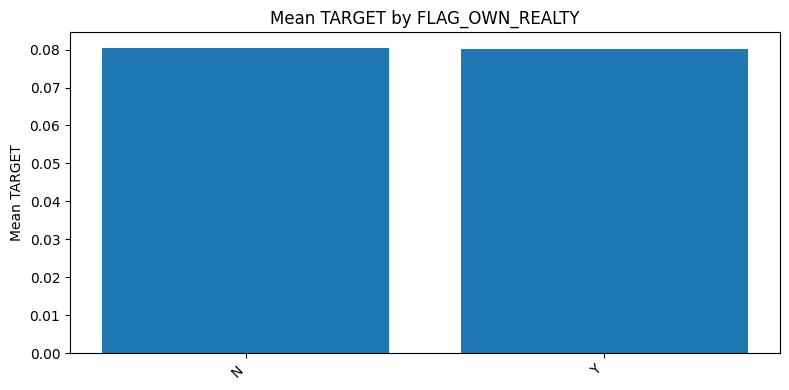

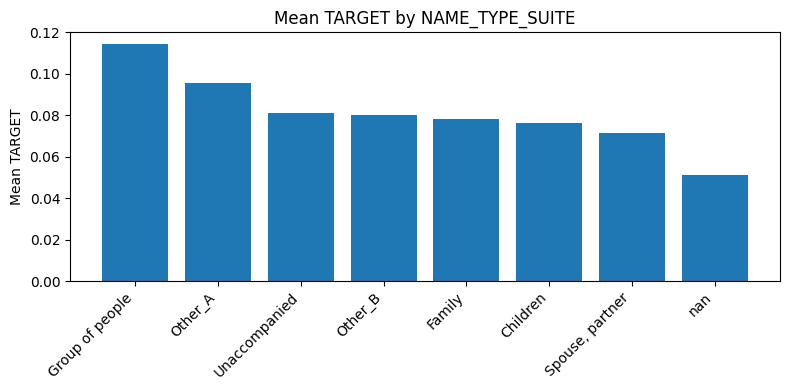

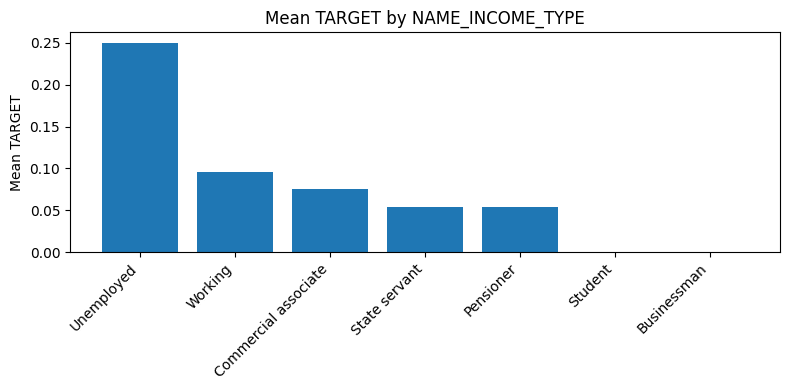

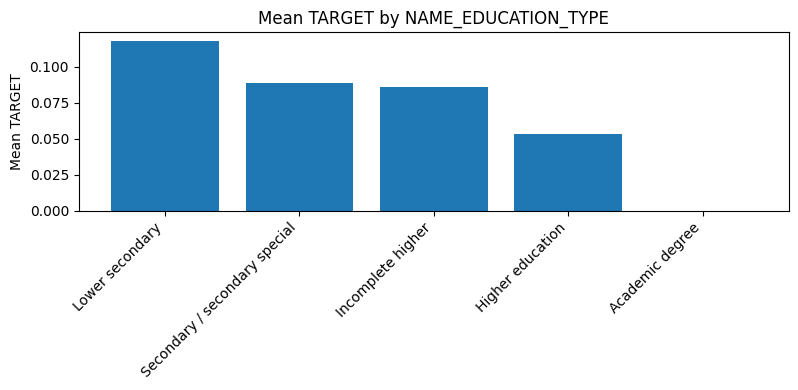

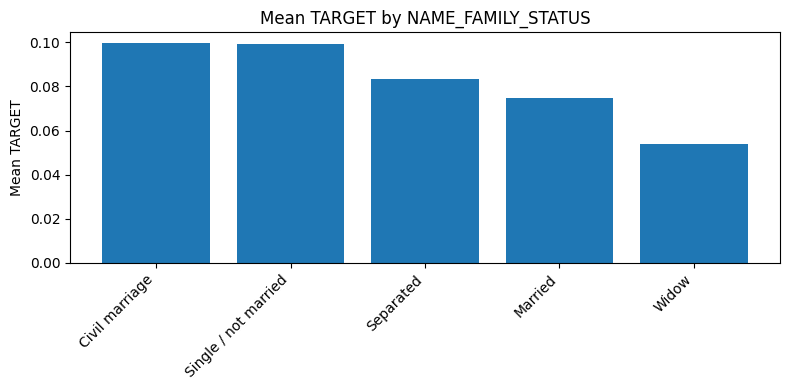

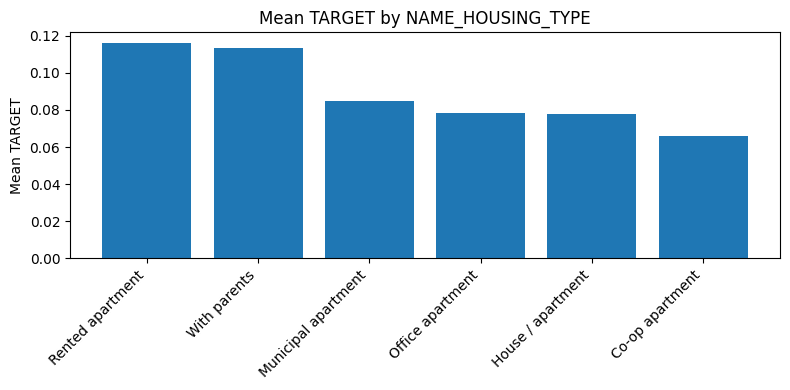

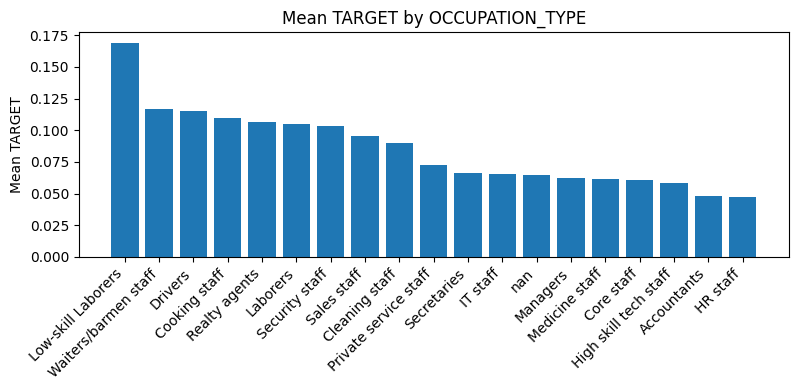

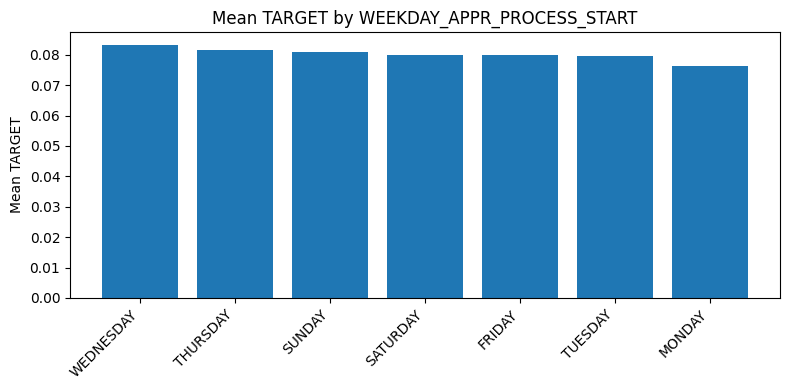

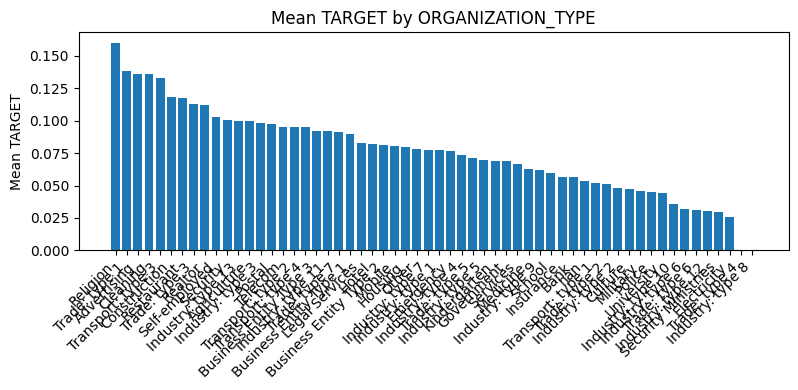

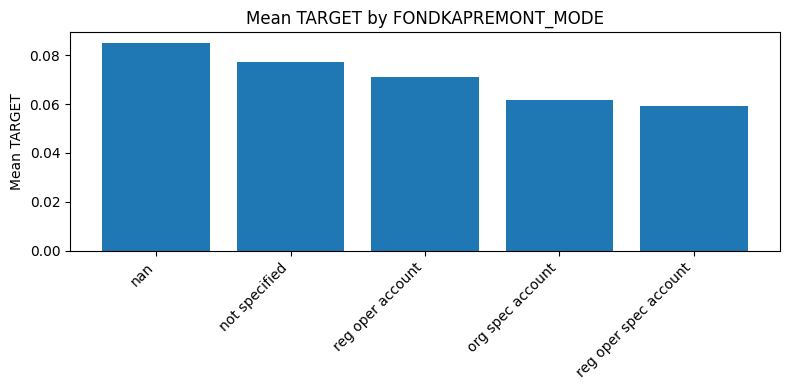

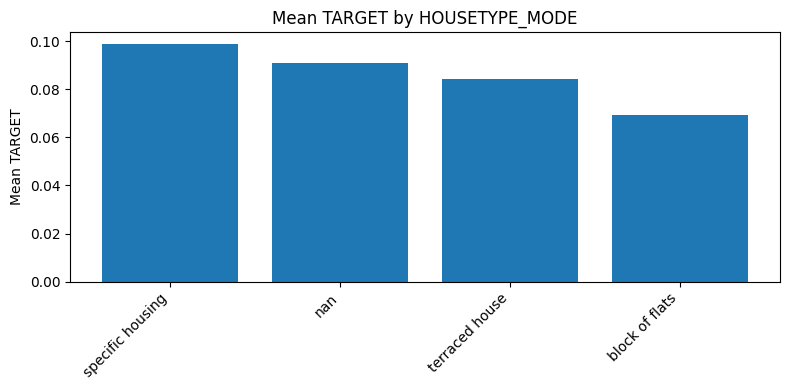

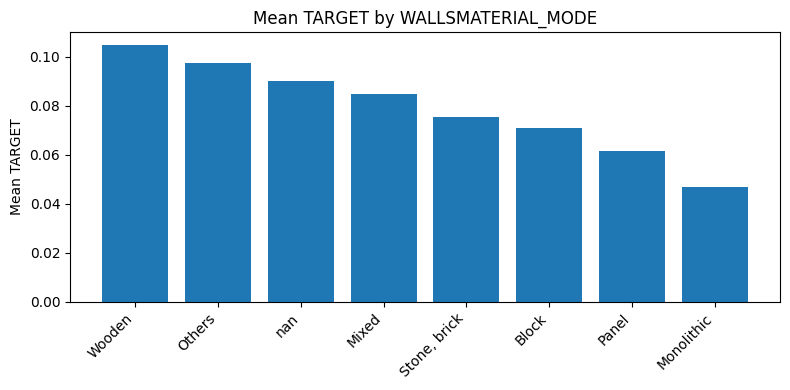

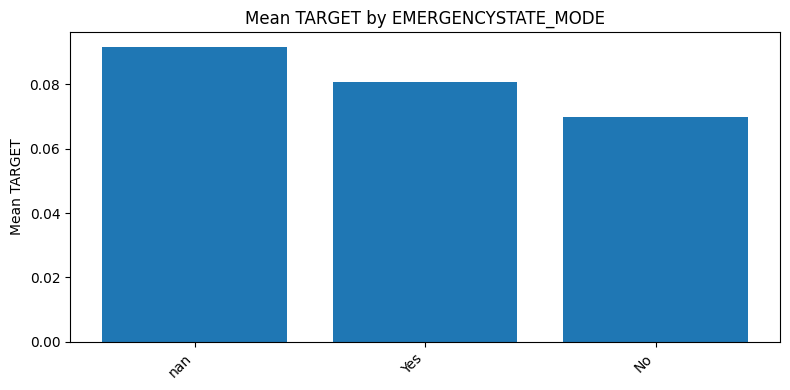

In [154]:
cbt = cat_bin_target.reset_index()

for col in cat_binary_cols:
    means = cbt[cbt['feature'] == col].copy()
    # сортировка по target_mean
    means = means.sort_values('target_mean', ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(means['category'].astype(str), means['target_mean'])
    ax.set_xticks(range(len(means)))
    ax.set_xticklabels(means['category'].astype(str), rotation=45, ha='right')
    ax.set_ylabel('Mean TARGET')
    ax.set_title(f'Mean TARGET by {col}')
    plt.tight_layout()
    plt.show()

## Краткие выводы по влиянию признаков на TARGET

1. **`EXT_SOURCE_1` / `EXT_SOURCE_2` / `EXT_SOURCE_3`**
   - Наиболее сильные по модулю предикторы.
   - Чем выше внешний скоринг, тем **ниже** вероятность дефолта.

2. **Возраст и стаж (`DAYS_BIRTH`, `DAYS_EMPLOYED`)**
   - Более взрослые клиенты имеют **меньший** риск дефолта.
   - `DAYS_EMPLOYED = 365243` — аномалия, значение должно рассматриваться отдельно.
   - Очищенный стаж сам по себе влияет умеренно, но полезен в сочетании с другими признаками.

3. **Региональные рейтинги (`REGION_RATING_CLIENT`, `REGION_RATING_CLIENT_W_CITY`)**
   - Хуже рейтинг региона/города клиента → **выше** риск дефолта.
   - Признаки важны как индикатор макро- и регионального риска.

4. **Агрегаты по кредитной истории (`MEAN/STD/MAX/MIN/DPD/AMTCR_*`)**
   - Наличие просрочек, высоких сумм и напряжённой кредитной активности связано с повышенным риском.
   - Признаки по прошлым кредитам дают значимый вклад в разделение «хороших» и «плохих» клиентов.

5. **Тип дохода (`NAME_INCOME_TYPE`)**
   - `Unemployed` и нестабильные типы занятости имеют риск **значительно выше** среднего.
   - `Pensioner`, `State servant` и некоторые стабильные категории — риск **ниже** среднего.
   - Признак один из ключевых категориальных предикторов.

6. **Уровень образования (`NAME_EDUCATION_TYPE`)**
   - Высшее образование связано с **минимальным** риском дефолта.
   - Более низкие уровни образования демонстрируют повышенный риск.
   - Образование задаёт устойчивый градиент риска.

7. **Тип контракта (`NAME_CONTRACT_TYPE`)**
   - `Cash loans` имеют более высокий риск дефолта.
   - `Revolving loans` в среднем менее рискованны.
   - Признак важен для сегментации по продукту.

8. **Пол и собственность (`CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`)**
   - Клиенты мужского пола в среднем более рискованные, чем женского.
   - Владение автомобилем и/или недвижимостью связано с **более низким** риском дефолта.
   - Флаги собственности и пола полезны как бинарные индикаторы.

9. **Пропуски и специальные значения**
   - Отсутствие информации (`NaN`, `XNA`, технические коды) по ряду признаков связано с иным уровнем риска, чем у «незаполненных» значений.
   - Пропуски и спецзначения следует рассматривать как отдельный риск-фактор (через категорию `"MISSING"` и/или отдельные флаги).


# 3. Предобработка

#### Логика

1. **Утечка данных:**
   - Все решения, зависящие от распределения данных (пропуски, медианы, частоты категорий, агрегирование редких категорий, список dummy-колонок) посчитаны только по X_train;
   - На X_valid мы только применяем уже обученные маппинги (медианы, флаги, частоты и т.п.).

2. **Пропуски и техзначения:**
   - inf / -inf, строковые маркеры (XNA, Unknown и др.) и код стажа 365243 приведены к NaN;
   - В числовых: медиана + флаг пропуска для «дырявых» столбцов;
   - В категориальных: отдельная категория "MISSING".

3. **Бинарные признаки:**
   - Бинарные числовые (0/1) и бинарные категориальные (M/F, Y/N и т.п.) приведены к единому формату 0/1;
   - Пропуски в бинарных заменены на -1 как отдельная «третья» категория.

4. **Редкие категории:**
   - В категориальных признаки категории с маленьким count на train агрегированы в "OTHER".

5. **Кодирование категориальных:**
   - Низкая кардинальность (≤10 категорий) → pd.get_dummies (one-hot);
   - Высокая кардинальность (>10 категорий) → frequency encoding (доля встречаемости категории на train) + дроп исходных колонок.

6. **Экстремально разреженные признаки (>95% пропусков):**
   - Для них создан бинарный флаг *_HAS_DATA (есть/нет наблюдаемого значения);
   - Исходные очень пустые колонки удалены, чтобы не тащить шум.

## 3.1 Приведение пропусков к единому формату

In [155]:
df = devsample.copy()
y = df['TARGET']
X = df.drop(columns=['TARGET'])

# 1. inf / -inf → NaN
X = X.replace([np.inf, -np.inf], np.nan)

# 2. Строковые маркеры "нет данных" → NaN
missing_tokens = ['XNA', 'Unknown', 'UNKNOWN', 'NA', 'N/A', '', ' ']
obj_cols_all = X.select_dtypes(include='object').columns.tolist()
for col in obj_cols_all:
    X[col] = X[col].replace(missing_tokens, np.nan)

# 3. Технический код стажа: DAYS_EMPLOYED == 365243 → NaN
if 'DAYS_EMPLOYED' in X.columns:
    X.loc[X['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan

## 3.2 Разделение на обучающую и валидационную выборку

Дальнейшая предобработка данных реализуется отдельно для train и valid для того, чтобы исключить Data Leakage

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_valid.shape

((64000, 196), (16000, 196))

## 3.3 Разбивка признаков по категориям

In [157]:
# 1. Определяем числовые и категориальные признаки по train
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 2. Выделяем бинарные числовые признаки (0/1)
binary_num_cols = []
for col in num_cols:
    vals = X_train[col].dropna().unique()
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        binary_num_cols.append(col)

# 3. Выделяем бинарные числовые признаки
nonbinary_num_cols = [c for c in num_cols if c not in binary_num_cols]

# 4. Выделяем условно бинарные категориальные признаки (2 уникальные категории на train)
binary_cat_cols = []
for col in cat_cols:
    vals = X_train[col].dropna().unique()
    if len(vals) == 2:
        binary_cat_cols.append(col)
nonbinary_cat_cols = [c for c in cat_cols if c not in binary_cat_cols]

print("Числовых небинарных:", len(nonbinary_num_cols))
print("Числовых бинарных:", len(binary_num_cols))
print("Категориальных небинарных:", len(nonbinary_cat_cols))
print("Категориальных бинарных:", len(binary_cat_cols))

Числовых небинарных: 140
Числовых бинарных: 39
Категориальных небинарных: 12
Категориальных бинарных: 5


## 3.4 Конвертация бинарных категориальных в 0/1

In [158]:
for col in binary_cat_cols:
    # берём уникальные значения по train, чтобы зафиксировать маппинг
    vals = sorted(X_train[col].dropna().unique())
    mapping = {vals[0]: 0, vals[1]: 1}
    
    # применяем один и тот же маппинг к train и valid
    X_train[col] = X_train[col].map(mapping)
    X_valid[col] = X_valid[col].map(mapping)

# После конвертации пересчитаем списки признаков
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
binary_num_cols = []
for col in num_cols:
    vals = X_train[col].dropna().unique()
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        binary_num_cols.append(col)
nonbinary_num_cols = [c for c in num_cols if c not in binary_num_cols]
print("Числовых:", len(nonbinary_num_cols))
print("Бинарных:", len(binary_num_cols))
print("Категориальных:", len(cat_cols))

Числовых: 140
Бинарных: 44
Категориальных: 12


## 3.5 Удаление разреженных столбцов

In [159]:
# Удаляем столбцы с экстремальным количеством пропусков (> 95% на train)
missing_ratio_train = X_train.isna().mean()
extreme_thresh = 0.95
extreme_cols = missing_ratio_train[missing_ratio_train > extreme_thresh].index.tolist()

print("Столбцов с пропусками > 95%:", len(extreme_cols))

# Для таких столбцов создадим бинарный индикатор "есть данные / нет данных", а исходный столбец удалим, чтобы не тащить кучу шума
for col in extreme_cols:
    has_data_col = col + '_HAS_DATA'
    # 1 = есть наблюдаемое значение, 0 = пропуск
    X_train[has_data_col] = X_train[col].notna().astype(int)
    X_valid[has_data_col] = X_valid[col].notna().astype(int)

# Удаляем исходные сильно разреженные колонки
X_train = X_train.drop(columns=extreme_cols)
X_valid = X_valid.drop(columns=extreme_cols)

Столбцов с пропусками > 95%: 18


## 3.6 Обработка пропусков

**Логика:**
   - Для числовых с небольшой долей пропусков (≤ 30%) → заполняем **медианой**;
   - Для числовых с большой долей пропусков (> 30%, но не попавших в экстремальные) →
создаём флаг `_IS_MISSING` и заполняем **медианой** (модель увидит факт пропуска отдельно);
   - Для бинарных числовых (0/1) пропуски заменяем на **-1** (третье значение «нет информации»).

### Числовые

In [160]:
import numpy as np
import pandas as pd

# пересчитываем числовые и категориальные признаки
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовых признаков:", len(num_cols))
print("Нечисловых признаков:", len(cat_cols))

# 1. бинарные числовые (0/1)
binary_num_cols = []
for col in num_cols:
    vals = X_train[col].dropna().unique()
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        binary_num_cols.append(col)

print("Бинарных числовых:", len(binary_num_cols))

# 2. доли пропусков по train
missing_ratio_num = X_train[num_cols].isna().mean()
high_missing_thresh = 0.30

# 3. список числовых колонок, для которых нужен флаг пропуска
miss_flag_cols = [
    col for col in num_cols
    if col not in binary_num_cols
    and missing_ratio_num[col] > high_missing_thresh
    and missing_ratio_num[col] > 0
]

print("Числовых c флагом пропуска:", len(miss_flag_cols))

# 4. считаем флаги пропуска одним махом
if miss_flag_cols:
    miss_flags_train = X_train[miss_flag_cols].isna().astype(int)
    miss_flags_valid = X_valid[miss_flag_cols].isna().astype(int)

    miss_flags_train.columns = [c + "_IS_MISSING" for c in miss_flag_cols]
    miss_flags_valid.columns = [c + "_IS_MISSING" for c in miss_flag_cols]
else:
    miss_flags_train = pd.DataFrame(index=X_train.index)
    miss_flags_valid = pd.DataFrame(index=X_valid.index)

# 5. заполняем пропуски в числовых
for col in num_cols:
    miss_r = missing_ratio_num[col]

    # бинарные числовые
    if col in binary_num_cols:
        if miss_r > 0:
            X_train[col] = X_train[col].fillna(-1)
            X_valid[col] = X_valid[col].fillna(-1)
        continue

    # небинарные
    if miss_r == 0:
        continue

    median = X_train[col].median()
    if np.isnan(median):
        median = 0  # на всякий случай

    X_train[col] = X_train[col].fillna(median)
    X_valid[col] = X_valid[col].fillna(median)

# 6. добавляем флаги пропуска
X_train = pd.concat([X_train, miss_flags_train], axis=1)
X_valid = pd.concat([X_valid, miss_flags_valid], axis=1)

Числовых признаков: 184
Нечисловых признаков: 12
Бинарных числовых: 56
Числовых c флагом пропуска: 99


### Категориальные

In [161]:
# пересчитываем категориальные ещё раз (вдруг что-то изменилось)
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Категориальных признаков:", len(cat_cols))

# 2.1. все пропуски → 'MISSING'
for col in cat_cols:
    X_train[col] = X_train[col].fillna('MISSING')
    X_valid[col] = X_valid[col].fillna('MISSING')

Категориальных признаков: 12


### Проверка

In [162]:
print("NaN в X_train (до финальной подстраховки):", X_train.isna().sum().sum())
print("NaN в X_valid (до финальной подстраховки):", X_valid.isna().sum().sum())

# Если всё равно остались NaN (например, после каких-то новых операций),
# добиваем их универсальным правилом: числовые -> медиана, категориальные -> 'MISSING'

# 3.1. числовые
for col in X_train.select_dtypes(include=[np.number]).columns:
    if X_train[col].isna().any() or X_valid[col].isna().any():
        median = X_train[col].median()
        if np.isnan(median):
            median = 0
        X_train[col] = X_train[col].fillna(median)
        X_valid[col] = X_valid[col].fillna(median)

# 3.2. категориальные/прочие
for col in X_train.select_dtypes(exclude=[np.number]).columns:
    if X_train[col].isna().any() or X_valid[col].isna().any():
        X_train[col] = X_train[col].fillna('MISSING')
        X_valid[col] = X_valid[col].fillna('MISSING')

print("NaN в X_train (после финальной подстраховки):", X_train.isna().sum().sum())
print("NaN в X_valid (после финальной подстраховки):", X_valid.isna().sum().sum())


NaN в X_train (до финальной подстраховки): 0
NaN в X_valid (до финальной подстраховки): 0
NaN в X_train (после финальной подстраховки): 0
NaN в X_valid (после финальной подстраховки): 0


## 3.7 Группировка редких категорий

In [163]:
min_count = 800
for col in cat_cols:
    vc = X_train[col].value_counts()
    rare_cats = vc[vc < min_count].index
    # все редкие значения заменяем на 'OTHER'
    X_train[col] = X_train[col].replace(rare_cats, 'OTHER')
    X_valid[col] = X_valid[col].replace(rare_cats, 'OTHER')

## 3.8 Кодировка категориальных признаков

In [164]:
from sklearn.model_selection import StratifiedKFold

# 1. Считаем кардинальность по train
cardinality = {col: X_train[col].nunique() for col in cat_cols}
low_card_cols = [c for c, k in cardinality.items() if k <= 10]
high_card_cols = [c for c, k in cardinality.items() if k > 10]

print("Низкая кардинальность (<=10):", len(low_card_cols))
print("Высокая кардинальность (>10):", len(high_card_cols))

# 2. Target encoding для high-card категориальных признаков
#    Используем StratifiedKFold по train:
#    - для train считаем out-of-fold значения (нет утечки внутри train);
#    - для valid кодируем по mapping, обученному на всём train.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

te_train = pd.DataFrame(index=X_train.index)
te_valid = pd.DataFrame(index=X_valid.index)

global_mean = y_train.mean()  # общий средний риск по train

for col in high_card_cols:
    print("Target encoding для:", col)
    
    x_tr = X_train[col]
    x_val = X_valid[col]

    oof = np.zeros(len(X_train), dtype=float)  # out-of-fold значения для train

    # KFold по train
    for tr_idx, val_idx in skf.split(x_tr, y_train):
        x_tr_fold = x_tr.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        # карта: категория -> средний TARGET на этом фолде
        mapping = y_tr_fold.groupby(x_tr_fold).mean()

        # применяем к валидационным строкам этого фолда
        encoded = x_tr.iloc[val_idx].map(mapping)
        # неизвестные категории → глобальное среднее
        encoded = encoded.fillna(global_mean)

        oof[val_idx] = encoded.values

    # сохраняем OOF-признак для train
    te_train[col + "_TE"] = oof

    # для valid используем mapping, обученный на всём train
    mapping_full = y_train.groupby(x_tr).mean()
    encoded_valid = x_val.map(mapping_full).fillna(global_mean)
    te_valid[col + "_TE"] = encoded_valid.values

# 3. One-hot кодирование для низко-кардинальных признаков (как было раньше)
X_train = pd.get_dummies(X_train, columns=low_card_cols, drop_first=False)
X_valid = pd.get_dummies(X_valid, columns=low_card_cols, drop_first=False)

# Выравниваем колонки valid под train (если каких-то dummy-колонок нет в valid)
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

# 4. Удаляем исходные high-card категориальные столбцы
X_train = X_train.drop(columns=high_card_cols)
X_valid = X_valid.drop(columns=high_card_cols)

# 5. Приклеиваем TE-признаки
X_train = pd.concat([X_train, te_train], axis=1)
X_valid = pd.concat([X_valid, te_valid], axis=1)

print("Финальные размеры после кодирования:")
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)


Низкая кардинальность (<=10): 10
Высокая кардинальность (>10): 2
Target encoding для: OCCUPATION_TYPE
Target encoding для: ORGANIZATION_TYPE
Финальные размеры после кодирования:
X_train: (64000, 330)
X_valid: (16000, 330)


# 4. Первая итерация построения моделей

## 4.1. Общая функция для оценки моделей

In [165]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="model"):
    
    # Предсказания вероятностей
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    # AUC
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_valid = roc_auc_score(y_valid, y_valid_pred)
    
    # Gini = 2 * AUC - 1
    gini_train = 2 * auc_train - 1
    gini_valid = 2 * auc_valid - 1
    
    print(f"=== {name} ===")
    print(f"Train AUC:  {auc_train:.4f} | Train Gini:  {gini_train:.4f}")
    print(f"Valid AUC:  {auc_valid:.4f} | Valid Gini:  {gini_valid:.4f}")
    return {
        "auc_train": auc_train,
        "auc_valid": auc_valid,
        "gini_train": gini_train,
        "gini_valid": gini_valid,
    }

## 4.2 Логистическая регрессия

Логистическая регрессия чувствительна к масштабам, но у нас уже есть нормальные числовые и бинарные признаки.
Для первого приближения можно пробовать без стандартизации.

In [166]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    penalty="l2",          # L2-регуляризация
    C=1.0,                 # сила регуляризации
    class_weight="balanced",  # учитываем дисбаланс классов
    solver="lbfgs",        # устойчивый солвер для средних размеров
    max_iter=1000,         # увеличиваем число итераций на всякий случай
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

log_results = evaluate_model(
    log_reg, X_train, y_train, X_valid, y_valid, 
    name="Logistic Regression (baseline)"
)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression (baseline) ===
Train AUC:  0.6277 | Train Gini:  0.2554
Valid AUC:  0.6232 | Valid Gini:  0.2464


## 4.3. XGBoost

In [167]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# дисбаланс
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / n_pos
print("scale_pos_weight:", scale_pos_weight)

xgb_clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.7,
    objective="binary:logistic",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",          # метрика
    early_stopping_rounds=50,
)

xgb_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=50,
)

# оценка
y_valid_pred = xgb_clf.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_valid_pred)
gini = 2 * auc - 1
print(f"AUC:  {auc:.4f}")
print(f"Gini: {gini:.4f}")


scale_pos_weight: 11.468342100136372
[0]	validation_0-auc:0.68390	validation_1-auc:0.67590
[50]	validation_0-auc:0.75177	validation_1-auc:0.73748
[100]	validation_0-auc:0.76801	validation_1-auc:0.74543
[150]	validation_0-auc:0.77912	validation_1-auc:0.74883
[200]	validation_0-auc:0.78832	validation_1-auc:0.74937
[243]	validation_0-auc:0.79512	validation_1-auc:0.74963
AUC:  0.7497
Gini: 0.4994


In [168]:
xgb_results = evaluate_model(
    xgb_clf, X_train, y_train, X_valid, y_valid, 
    name="XGBoost"
)

=== XGBoost ===
Train AUC:  0.7872 | Train Gini:  0.5744
Valid AUC:  0.7497 | Valid Gini:  0.4994


# 5. Feature Engineering

## 5.1 Признаки возраста и стажа

In [169]:
# Используем уже очищенные DAYS_BIRTH и DAYS_EMPLOYED.
# Преобразования построчные, таргет не используется → утечки нет.

if 'DAYS_BIRTH' in X_train.columns:
    for df in (X_train, X_valid):
        # возраст в годах (DAYS_BIRTH < 0, поэтому берём знак минус)
        df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365.25

if 'DAYS_EMPLOYED' in X_train.columns:
    for df in (X_train, X_valid):
        # стаж в годах (аналогично)
        df['EMPLOYED_YEARS'] = -df['DAYS_EMPLOYED'] / 365.25

## 5.2 Отношения сумм и дохода

Защищаемся от деления на ноль: если знаменатель 0 или NaN → ставим 0 в новой фиче.

### 5.2.1. CREDIT_INCOME_RATIO = AMT_CREDIT / AMT_INCOME_TOTAL

In [170]:
if ('AMT_CREDIT' in X_train.columns) and ('AMT_INCOME_TOTAL' in X_train.columns):
    for df in (X_train, X_valid):
        denom = df['AMT_INCOME_TOTAL'].replace(0, np.nan)
        ratio = df['AMT_CREDIT'] / denom
        df['CREDIT_INCOME_RATIO'] = ratio.fillna(0.0)

### 5.2.2. ANNUITY_INCOME_RATIO = AMT_ANNUITY / AMT_INCOME_TOTAL

In [171]:
if ('AMT_ANNUITY' in X_train.columns) and ('AMT_INCOME_TOTAL' in X_train.columns):
    for df in (X_train, X_valid):
        denom = df['AMT_INCOME_TOTAL'].replace(0, np.nan)
        ratio = df['AMT_ANNUITY'] / denom
        df['ANNUITY_INCOME_RATIO'] = ratio.fillna(0.0)

### 5.2.3. CREDIT_TERM_YEARS ≈ срок кредита в годах = (AMT_CREDIT / AMT_ANNUITY) / 12

In [172]:
if ('AMT_CREDIT' in X_train.columns) and ('AMT_ANNUITY' in X_train.columns):
    for df in (X_train, X_valid):
        denom = df['AMT_ANNUITY'].replace(0, np.nan)
        months = df['AMT_CREDIT'] / denom
        years = (months / 12.0).replace([np.inf, -np.inf], np.nan)
        df['CREDIT_TERM_YEARS'] = years.fillna(0.0)

### 5.2.4 GOODS_CREDIT_RATIO = AMT_GOODS_PRICE / AMT_CREDIT

In [173]:
if ('AMT_GOODS_PRICE' in X_train.columns) and ('AMT_CREDIT' in X_train.columns):
    for df in (X_train, X_valid):
        denom = df['AMT_CREDIT'].replace(0, np.nan)
        ratio = df['AMT_GOODS_PRICE'] / denom
        df['GOODS_CREDIT_RATIO'] = ratio.fillna(0.0)

## 5.3 Агрегаты по внешним скорингам EXT_SOURCE_1/2/3

Эти признаки очень важны по важности модели, поэтому добавляем агрегаты

In [174]:
ext_cols = [c for c in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
            if c in X_train.columns]

if len(ext_cols) > 0:
    for df in (X_train, X_valid):
        # среднее, минимум и максимум по доступным EXT_SOURCE
        df['EXT_SOURCES_MEAN'] = df[ext_cols].mean(axis=1)
        df['EXT_SOURCES_MIN']  = df[ext_cols].min(axis=1)
        df['EXT_SOURCES_MAX']  = df[ext_cols].max(axis=1)

## 5.4 Признаки времени и даты

### 5.4.1 DAY

In [175]:
if 'DAY' in X_train.columns:
    for df in (X_train, X_valid):
        # аккуратно приводим к целому (чтобы убрать .0), NaN оставляем как есть
        day_int = df['DAY'].round().astype('Int64')              # допускает NaN
        day_str = day_int.astype('string')                       # строка вида "20180115"
        day_dt = pd.to_datetime(day_str, format='%Y%m%d', errors='coerce')

        # Год, месяц, день недели, день года
        df['APP_YEAR']       = day_dt.dt.year.fillna(0).astype(int)
        df['APP_MONTH']      = day_dt.dt.month.fillna(0).astype(int)
        df['APP_DAYOFWEEK']  = day_dt.dt.dayofweek.fillna(-1).astype(int)   # 0=понедельник, 6=воскресенье
        df['APP_DAYOFYEAR']  = day_dt.dt.dayofyear.fillna(0).astype(int)

        # Выходной / будний (суббота=5, воскресенье=6)
        df['APP_IS_WEEKEND'] = df['APP_DAYOFWEEK'].isin([5, 6]).astype(int)


### 5.4.2 MONTH

In [176]:
# Предполагаем, что MONTH хранится как целое YYYYMM (например 201801)
if 'MONTH' in X_train.columns:
    for df in (X_train, X_valid):
        month_int = df['MONTH'].round().astype('Int64')
        month_str = month_int.astype('string') + '01'            # делаем YYYYMM01
        month_dt = pd.to_datetime(month_str, format='%Y%m%d', errors='coerce')

        df['APP_M_YEAR']  = month_dt.dt.year.fillna(0).astype(int)
        df['APP_M_MONTH'] = month_dt.dt.month.fillna(0).astype(int)

## 5.4.3 TIME

In [177]:
if 'TIME' in X_train.columns:
    for df in (X_train, X_valid):
        time_int = df['TIME'].round().astype('Int64')

        # Часы и минуты
        hour   = (time_int // 100).astype('Int64')
        minute = (time_int % 100).astype('Int64')

        df['APP_HOUR']   = hour.fillna(-1).astype(int)
        df['APP_MINUTE'] = minute.fillna(0).astype(int)

        # Признак "ночная заявка" (условно с 22:00 до 6:00)
        df['APP_IS_NIGHT'] = ((df['APP_HOUR'] >= 22) | (df['APP_HOUR'] <= 6)).astype(int)

        # Признак "рабочие часы" (условно 9–18)
        df['APP_IS_WORKTIME'] = ((df['APP_HOUR'] >= 9) & (df['APP_HOUR'] <= 18)).astype(int)

## 5.5 Проверка размеров датасетов

In [178]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

print("NaN в новых фичах train:", X_train[X_train.columns].isna().sum().sum())
print("NaN в новых фичах valid:", X_valid[X_valid.columns].isna().sum().sum())

X_train shape: (64000, 346)
X_valid shape: (16000, 346)
NaN в новых фичах train: 0
NaN в новых фичах valid: 0


# 6. Вторая итерация построения XGBoost

## 6.1 Аналог кросс-валидации для обучения
**Логика:**
   - Выборки объединяются и разбиваются на К фолдов
   - На одной итерации новая модель обучается на К-1 фолдах и валидируется на оставшемся
   - Все получившиеся К моделей сохраняются
   - Полученные метрики усредняются. Для получения предсказаний данные будут прогоняться через все сохраненные модели, а результаты усредняться

**Что дает?**
  - **Используются все данные** - каждый объект несколько раз участвует в обучении (в разных моделях на разных фолдах), а не сидит один раз в валидейшене «бездельником»
  - **Уменьшает переобучение и шум** - разные модели видят немного разные выборки → усреднение сглаживает случайный шум
  - **Усреднение моделей** - вместо одной модели, которая может чуть переобучиться на свой train, их несколько, и среднее результатов должно давать более высокий Gini

In [180]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# 1. Объединяем текущие train/valid в одну выборку для CV
X_all = pd.concat([X_train, X_valid], axis=0).reset_index(drop=True)
y_all = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)

print("Полный датасет для CV:", X_all.shape)

# 2. Стратифицированный KFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 3. Настройки XGBoost
n_pos = (y_all == 1).sum()
n_neg = (y_all == 0).sum()
scale_pos_weight = n_neg / n_pos
print("scale_pos_weight:", scale_pos_weight)

base_params = dict(
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.7,
    objective="binary:logistic",
    tree_method="hist",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    early_stopping_rounds=50,
)

# 4. Массив для out-of-fold предсказаний и список моделей
oof_pred = np.zeros(len(X_all))
models = []

# 5. Цикл по фолдам
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_all, y_all), 1):
    print(f"\n===== Fold {fold}/{n_splits} =====")

    X_tr, X_val = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[tr_idx], y_all.iloc[val_idx]

    params = base_params.copy()
    params["random_state"] = 42 + fold  # чуть разный сид для каждого фолда

    model = XGBClassifier(**params)

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=False,
    )

    # сохраняем модель
    models.append(model)

    # предсказания на валидационном фолде (out-of-fold)
    oof_pred[val_idx] = model.predict_proba(X_val)[:, 1]

    # метрика по фолду
    auc_fold = roc_auc_score(y_val, oof_pred[val_idx])
    gini_fold = 2 * auc_fold - 1
    print(f"Fold {fold} AUC: {auc_fold:.4f} | Gini: {gini_fold:.4f}")

# 6. Общая CV-метрика по всем фолдам
auc_cv = roc_auc_score(y_all, oof_pred)
gini_cv = 2 * auc_cv - 1
print("\n===== Итог по CV =====")
print(f"CV AUC:  {auc_cv:.4f}")
print(f"CV Gini: {gini_cv:.4f}")

# 7. models — это ансамбль из {n_splits} моделей для дальнейшего использования
print(f"\nОбучено моделей: {len(models)}")


Полный датасет для CV: (80000, 346)
scale_pos_weight: 11.468827930174564

===== Fold 1/5 =====
Fold 1 AUC: 0.7515 | Gini: 0.5030

===== Fold 2/5 =====
Fold 2 AUC: 0.7556 | Gini: 0.5112

===== Fold 3/5 =====
Fold 3 AUC: 0.7647 | Gini: 0.5295

===== Fold 4/5 =====
Fold 4 AUC: 0.7648 | Gini: 0.5297

===== Fold 5/5 =====
Fold 5 AUC: 0.7322 | Gini: 0.4644

===== Итог по CV =====
CV AUC:  0.7539
CV Gini: 0.5078

Обучено моделей: 5


## 6.2 Проверка новых моделей на старом валидационном датасете

In [181]:
from sklearn.metrics import roc_auc_score
import numpy as np

# valid-ансамбль: среднее предсказаний всех фолдов на "старой" валидации
valid_pred_ens = np.zeros(len(X_valid))

for model in models:
    valid_pred_ens += model.predict_proba(X_valid)[:, 1] / len(models)

auc_valid_ens = roc_auc_score(y_valid, valid_pred_ens)
gini_valid_ens = 2 * auc_valid_ens - 1

print(f"Ensemble Valid AUC:  {auc_valid_ens:.4f}")
print(f"Ensemble Valid Gini: {gini_valid_ens:.4f}")


Ensemble Valid AUC:  0.8169
Ensemble Valid Gini: 0.6337


**Выводы:**
  - Такой большой результат - следствие утечки данных. Каждая модель обучалась на всем датасете, в том числе и на валидационном
  - Теперь лучше результат вряд-ли получится сделать - переходим к формированию ответа

# 7. Обучение на полном train. Прогон тестовых данных и формирование submit

## 7.1 Загрузка и объединение датасетов

Нужно для высчитывания метрик на тестовом датасете, чтобы модель не встречала новые данные

In [212]:
# Пути к файлам – при необходимости поправь
train_path = '/kaggle/input/credit-risk-scoring-with-xgboost2023/data_devsample.csv'
test_path  = '/kaggle/input/credit-risk-scoring-with-xgboost2023/data_to_score.csv'

train_raw = pd.read_csv(train_path)
test_raw  = pd.read_csv(test_path)

print("Train shape:", train_raw.shape)
print("Test  shape:", test_raw.shape)

target_col = "TARGET"
id_col     = "SK_ID_CURR"

# Добавляем флаг train/test и объединяем
train_raw["is_train"] = 1
test_raw["is_train"]  = 0

# У теста нет TARGET – колонка появится с NaN после concat
full = pd.concat([train_raw, test_raw], axis=0, ignore_index=True)
print("Full shape:", full.shape)

# Маска train-части
train_mask = full["is_train"] == 1


Train shape: (80000, 197)
Test  shape: (100000, 196)
Full shape: (180000, 198)


## 7.2 Базовая чистка: inf, аномалии, пропуски, бинарные строки

In [213]:
# Заменяем ±inf на NaN
full = full.replace([np.inf, -np.inf], np.nan)

# Обработка аномалии по стажу (365243)
if "DAYS_EMPLOYED" in full.columns:
    full["DAYS_EMPLOYED_ANOM"] = (full["DAYS_EMPLOYED"] == 365243).astype(int)
    full.loc[full["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

# Маркеры "технических" пропусков в строках
missing_tokens = ["XNA", "Unknown", "UNKNOWN", "NA", "N/A", "", " "]

obj_cols = full.select_dtypes(include="object").columns.tolist()
for col in obj_cols:
    full[col] = full[col].replace(missing_tokens, np.nan)

# Перевод явных бинарных строковых колонок в 0/1 (Y/N, M/F)
obj_cols = full.select_dtypes(include="object").columns.tolist()
binary_mapped = []

for col in obj_cols:
    vals = set(full[col].dropna().unique())
    if vals.issubset({"Y", "N"}):
        full[col] = full[col].map({"Y": 1, "N": 0})
        binary_mapped.append(col)
    elif vals.issubset({"N", "Y"}):
        full[col] = full[col].map({"Y": 1, "N": 0})
        binary_mapped.append(col)
    elif vals.issubset({"M", "F"}):
        full[col] = full[col].map({"M": 1, "F": 0})
        binary_mapped.append(col)

print("Строковые бинарные, переведённые в 0/1:", binary_mapped)


Строковые бинарные, переведённые в 0/1: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


## 7.3 Числовые признаки: пропуски, флаги пропусков

In [214]:
# Разделяем признаки
feature_cols = [c for c in full.columns if c not in [target_col, "is_train"]]
num_cols = full[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = full[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

# ID не используем как признак
if id_col in num_cols: num_cols.remove(id_col)
if id_col in cat_cols: cat_cols.remove(id_col)

print("Числовых признаков:", len(num_cols))
print("Категориальных признаков:", len(cat_cols))

# Бинарные числовые (0/1)
binary_num_cols = []
for col in num_cols:
    vals = set(full.loc[train_mask, col].dropna().unique())
    if len(vals) <= 2 and vals.issubset({0, 1}):
        binary_num_cols.append(col)

nonbinary_num_cols = [c for c in num_cols if c not in binary_num_cols]
print("Бинарных числовых:", len(binary_num_cols))
print("Небинарных числовых:", len(nonbinary_num_cols))

# Доли пропусков по train
missing_ratio_num = full.loc[train_mask, num_cols].isna().mean()
high_missing_thresh = 0.30

# Удалим совсем "пустые" числовые (>95% пропусков)
drop_num_cols = missing_ratio_num[missing_ratio_num > 0.95].index.tolist()
print("Числовые с >95% пропусков, удаляем:", drop_num_cols)

full = full.drop(columns=drop_num_cols)
num_cols = [c for c in num_cols if c not in drop_num_cols]
missing_ratio_num = missing_ratio_num.drop(drop_num_cols, errors="ignore")

# Флаги пропусков для сильно разреженных небинарных числовых
miss_flag_cols = [
    c for c in num_cols
    if c in nonbinary_num_cols
    and missing_ratio_num.get(c, 0) > high_missing_thresh
    and missing_ratio_num.get(c, 0) > 0
]

print("Флаги пропусков добавлены для:", miss_flag_cols)

if miss_flag_cols:
    # считаем все флаги одним махом и конкатим за один раз
    miss_flags = full[miss_flag_cols].isna().astype(int)
    miss_flags.columns = [c + "_IS_MISSING" for c in miss_flag_cols]

    full = pd.concat([full, miss_flags], axis=1)
    # опционально: дефрагментировать датафрейм
    full = full.copy()


# Импутация числовых
for col in num_cols:
    miss_r = missing_ratio_num.get(col, 0)

    if col in binary_num_cols:
        if miss_r > 0:
            full[col] = full[col].fillna(-1)   # отдельная категория "нет данных"
        continue

    if miss_r > 0:
        median = full.loc[train_mask, col].median()
        if np.isnan(median):
            median = 0
        full[col] = full[col].fillna(median)

Числовых признаков: 182
Категориальных признаков: 14
Бинарных числовых: 43
Небинарных числовых: 139
Числовые с >95% пропусков, удаляем: ['STD_AMTCR_0M_6M', 'STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE', 'MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED', 'MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED', 'MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED', 'MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED', 'STD_AMTCR_0M_6M_TYPE_EQ_CLOSED', 'STD_DPD_0M_6M', 'STD_DPD_0M_6M_TYPE_EQ_ACTIVE', 'MIN_DPD_0M_6M_TYPE_EQ_CLOSED', 'MAX_DPD_0M_6M_TYPE_EQ_CLOSED', 'MEAN_DPD_0M_6M_TYPE_EQ_CLOSED', 'MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED', 'STD_DPD_0M_6M_TYPE_EQ_CLOSED', 'MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M', 'MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE', 'MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED', 'MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_CLOSED']
Флаги пропусков добавлены для: ['CNT_CHILDREN', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_B

## 7.4 Категориальные признаки: пропуски, редкие категории, target encoding для high-card

In [215]:
from sklearn.model_selection import StratifiedKFold

# Переопределяем список всех признаков после удалений в 7.3
feature_cols = [c for c in full.columns if c not in [target_col, "is_train"]]

# Обновляем список категориальных признаков
cat_cols = full[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()
if id_col in cat_cols:
    cat_cols.remove(id_col)

print("Категориальных признаков (после числовых преобразований):", len(cat_cols))

# 1. Заполнение пропусков и группировка редких категорий
min_count = 100  # минимум наблюдений для отдельной категории

for col in cat_cols:
    # пропуски -> 'MISSING'
    full[col] = full[col].fillna("MISSING").astype(str)

    # редкие категории в train -> 'OTHER'
    vc = full.loc[train_mask, col].value_counts()
    rare = vc[vc < min_count].index
    if len(rare) > 0:
        full[col] = full[col].replace(rare, "OTHER")

# 2. Делим на low-card и high-card по train
cardinality = {col: full.loc[train_mask, col].nunique() for col in cat_cols}
low_card_cols  = [c for c, k in cardinality.items() if k <= 10]
high_card_cols = [c for c, k in cardinality.items() if k > 10]

print("Низкая кардинальность (<=10):", len(low_card_cols))
print("Высокая кардинальность (>10):", len(high_card_cols))

# 3. Таргет для TE: просто заменяем NaN на 0 (таргет бинарный, это безопасно)
y_train_te = full.loc[train_mask, target_col].fillna(0).astype(int).reset_index(drop=True)
global_mean = y_train_te.mean()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Target encoding для high-card признаков
for col in high_card_cols:
    print("Target encoding для:", col)

    # значения признака для train-части и всех строк
    x_tr = full.loc[train_mask, col].reset_index(drop=True)
    x_all = full[col]

    # out-of-fold значения для train
    oof = np.zeros(len(x_tr), dtype=float)

    for tr_idx, val_idx in skf.split(x_tr, y_train_te):
        x_tr_fold = x_tr.iloc[tr_idx]
        y_tr_fold = y_train_te.iloc[tr_idx]

        mapping = y_tr_fold.groupby(x_tr_fold).mean()

        enc = x_tr.iloc[val_idx].map(mapping)
        enc = enc.fillna(global_mean)

        oof[val_idx] = enc.values

    # записываем TE для train-строк
    full.loc[train_mask, col + "_TE"] = oof

    # mapping по всему train для тестовых строк
    mapping_full = y_train_te.groupby(x_tr).mean()
    enc_test = x_all.loc[~train_mask].map(mapping_full).fillna(global_mean)

    full.loc[~train_mask, col + "_TE"] = enc_test.values

# 5. Удаляем исходные high-card признаки, оставляем только их TE-версии
full = full.drop(columns=high_card_cols)
cat_cols = [c for c in cat_cols if c not in high_card_cols]

Категориальных признаков (после числовых преобразований): 14
Низкая кардинальность (<=10): 11
Высокая кардинальность (>10): 3
Target encoding для: OCCUPATION_TYPE
Target encoding для: ORGANIZATION_TYPE
Target encoding для: TIME


/tmp/ipykernel_47/3431734751.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full.loc[train_mask, col + "_TE"] = oof
/tmp/ipykernel_47/3431734751.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full.loc[train_mask, col + "_TE"] = oof
/tmp/ipykernel_47/3431734751.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

## 7.5 One-hot кодирование малокатогорийных признаков

In [216]:
# OHE только для low-card колонок
full = pd.get_dummies(full, columns=low_card_cols, drop_first=False)

print("Форма full после OHE:", full.shape)

Форма full после OHE: (180000, 328)


## 7.6 Добавление признаков

In [217]:
# Возраст и стаж
if "DAYS_BIRTH" in full.columns:
    full["AGE_YEARS"] = -full["DAYS_BIRTH"] / 365.25

if "DAYS_EMPLOYED" in full.columns:
    full["EMPLOYED_YEARS"] = -full["DAYS_EMPLOYED"] / 365.25

# Денежные отношения
if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(full.columns):
    denom = full["AMT_INCOME_TOTAL"].replace(0, np.nan)
    full["CREDIT_INCOME_RATIO"] = (full["AMT_CREDIT"] / denom).fillna(0)

if {"AMT_ANNUITY", "AMT_INCOME_TOTAL"}.issubset(full.columns):
    denom = full["AMT_INCOME_TOTAL"].replace(0, np.nan)
    full["ANNUITY_INCOME_RATIO"] = (full["AMT_ANNUITY"] / denom).fillna(0)

if {"AMT_CREDIT", "AMT_ANNUITY"}.issubset(full.columns):
    denom = full["AMT_ANNUITY"].replace(0, np.nan)
    months = (full["AMT_CREDIT"] / denom).replace([np.inf, -np.inf], np.nan)
    full["CREDIT_TERM_YEARS"] = (months / 12.0).fillna(0)

if {"AMT_GOODS_PRICE", "AMT_CREDIT"}.issubset(full.columns):
    denom = full["AMT_CREDIT"].replace(0, np.nan)
    full["GOODS_CREDIT_RATIO"] = (full["AMT_GOODS_PRICE"] / denom).fillna(0)

# Агрегаты по EXT_SOURCE
ext_cols = [c for c in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"] if c in full.columns]
if ext_cols:
    full["EXT_SOURCES_MEAN"] = full[ext_cols].mean(axis=1)
    full["EXT_SOURCES_MIN"]  = full[ext_cols].min(axis=1)
    full["EXT_SOURCES_MAX"]  = full[ext_cols].max(axis=1)

# Фичи из DAY
if "DAY" in full.columns:
    day_int = full["DAY"].round().astype("Int64")
    day_str = day_int.astype("string")
    day_dt  = pd.to_datetime(day_str, format="%Y%m%d", errors="coerce")

    full["APP_YEAR"]       = day_dt.dt.year.fillna(0).astype(int)
    full["APP_MONTH"]      = day_dt.dt.month.fillna(0).astype(int)
    full["APP_DAYOFWEEK"]  = day_dt.dt.dayofweek.fillna(-1).astype(int)
    full["APP_DAYOFYEAR"]  = day_dt.dt.dayofyear.fillna(0).astype(int)
    full["APP_IS_WEEKEND"] = full["APP_DAYOFWEEK"].isin([5, 6]).astype(int)

# Фичи из MONTH (YYYYMM)
if "MONTH" in full.columns:
    month_int = full["MONTH"].round().astype("Int64")
    month_str = month_int.astype("string") + "01"
    month_dt  = pd.to_datetime(month_str, format="%Y%m%d", errors="coerce")

    full["APP_M_YEAR"]  = month_dt.dt.year.fillna(0).astype(int)
    full["APP_M_MONTH"] = month_dt.dt.month.fillna(0).astype(int)

# Фичи из TIME (HHMM)
if "TIME" in full.columns:
    time_int = full["TIME"].round().astype("Int64")
    hour   = (time_int // 100).astype("Int64")
    minute = (time_int % 100).astype("Int64")

    full["APP_HOUR"]        = hour.fillna(-1).astype(int)
    full["APP_MINUTE"]      = minute.fillna(0).astype(int)
    full["APP_IS_NIGHT"]    = ((full["APP_HOUR"] >= 22) | (full["APP_HOUR"] <= 6)).astype(int)
    full["APP_IS_WORKTIME"] = ((full["APP_HOUR"] >= 9) & (full["APP_HOUR"] <= 18)).astype(int)

# Лог-признаки для денежных столбцов
log_feats = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]
for col in log_feats:
    if col in full.columns:
        full[col + "_LOG"] = np.log1p(full[col].clip(lower=0))

print("Форма full после FE:", full.shape)

Форма full после FE: (180000, 348)


## 7.7 Финальное разделение на train/test матрицы признаков

In [218]:
train_final = full[train_mask].copy()
test_final  = full[~train_mask].copy()

y_train = (
    train_final[target_col]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(int)
)

X_train = train_final.drop(columns=[target_col, "is_train"])
X_test  = test_final.drop(columns=[target_col, "is_train"])

# Сохраняем ID для сабмита и убираем из признаков
test_ids = X_test[id_col].values
X_train = X_train.drop(columns=[id_col])
X_test  = X_test.drop(columns=[id_col])

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

print("NaN в X_train:", X_train.isna().sum().sum())
print("NaN в X_test :", X_test.isna().sum().sum())


X_train: (80000, 345)
X_test : (100000, 345)
NaN в X_train: 0
NaN в X_test : 1


## 7.8 Обучение KFold-ансамбля XGBoost

In [219]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

print("Распределение TARGET в train:")
print(y_train.value_counts())

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)
print("scale_pos_weight:", scale_pos_weight)

base_params = dict(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    early_stopping_rounds=50,
)

oof_pred = np.zeros(len(X_train))
models = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n===== Fold {fold}/{n_splits} =====")

    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    params = base_params.copy()
    params["random_state"] = 42 + fold

    model = XGBClassifier(**params)

    # eval_set можно оставить прежним — предупреждения от XGBoost не критичны
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        verbose=False,
    )

    models.append(model)

    # OOF-предсказания
    oof_pred[val_idx] = model.predict_proba(X_val)[:, 1]

    # Если в y_val только один класс, AUC посчитать нельзя — пропускаем
    if y_val.nunique() < 2:
        print("Fold", fold, ": только один класс в y_val, AUC/Gini не считаем")
    else:
        auc_fold = roc_auc_score(y_val, oof_pred[val_idx])
        gini_fold = 2 * auc_fold - 1
        print(f"Fold {fold} AUC:  {auc_fold:.4f} | Gini: {gini_fold:.4f}")

# Общая CV-метрика по всем фолдам (здесь классов точно два)
auc_cv = roc_auc_score(y_train, oof_pred)
gini_cv = 2 * auc_cv - 1

print("\n===== Итог по CV =====")
print(f"CV AUC:  {auc_cv:.4f}")
print(f"CV Gini: {gini_cv:.4f}")
print("\nОбучено моделей:", len(models))

Распределение TARGET в train:
TARGET
0    73584
1     6416
Name: count, dtype: int64
scale_pos_weight: 11.468827930174564

===== Fold 1/5 =====
Fold 1 AUC:  0.7594 | Gini: 0.5187

===== Fold 2/5 =====
Fold 2 AUC:  0.7492 | Gini: 0.4984

===== Fold 3/5 =====
Fold 3 AUC:  0.7544 | Gini: 0.5088

===== Fold 4/5 =====
Fold 4 AUC:  0.7585 | Gini: 0.5171

===== Fold 5/5 =====
Fold 5 AUC:  0.7502 | Gini: 0.5004

===== Итог по CV =====
CV AUC:  0.7539
CV Gini: 0.5079

Обучено моделей: 5


## 7.9 Предсказание на тесте и формирование submission

In [220]:
# Ансамблевое предсказание на тесте
test_pred = np.zeros(len(X_test))
for model in models:
    test_pred += model.predict_proba(X_test)[:, 1] / len(models)

# Формируем сабмит
submission = pd.DataFrame({
    "SK_ID_CURR": test_ids,
    "SCORE": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

,SK_ID_CURR,SCORE
0,215138,0.481336
1,325963,0.629451
2,206923,0.178862
3,265855,0.456997
4,359795,0.253099
